<a href="https://colab.research.google.com/github/MHosseinHashemi/Image_Similarity_CenterLoss_TripletLoss/blob/main/LFW_Refined_with_CenterLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import random
import tarfile
import scipy.io
import shutil
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from tensorflow.keras import *
from itertools import combinations
from sklearn.model_selection import *
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, Dense, Dropout, Lambda, BatchNormalization, GlobalAveragePooling2D

# Download And Extarct The data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

urls = [
    "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
    "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz",
    "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/distancematrices102.mat",
    'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
    'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'

]

destination_folder = "/content/drive/MyDrive/dataset"

for url in tqdm(urls):
    os.system(f"wget -P {destination_folder} {url}")

# Data Preprocess

In [ ]:
def mat_to_csv(mat_address):
    # Load Mat Files
    mat_dic = scipy.io.loadmat(mat_address)
    filtered_mat_dic = {}
    for key, value in tqdm(mat_dic.items()):
        if key[0] != "_":
          filtered_mat_dic[key] = value

    data = pd.DataFrame({k: pd.Series(v[0]) for k, v in filtered_mat_dic.items()})
    del mat_dic # Release part.0
    data.to_csv(mat_address.rstrip(".mat")+".csv", index=False)
    del data # Release part.1

In [ ]:
paths = ['/content/drive/MyDrive/dataset/imagelabels.mat',
         '/content/drive/MyDrive/dataset/setid.mat',
         '/content/drive/MyDrive/dataset/distancematrices102.mat']

for path in tqdm(paths):
    mat_to_csv(path)

In [ ]:
def extract_tars(tar_path):
    file = tarfile.open(tar_path)
    file.extractall(tar_path.rstrip(".tgz"))
    file.close()

tar_paths = ['/content/drive/MyDrive/dataset/102flowers.tgz',
             '/content/drive/MyDrive/dataset/102segmentations.tgz']

for path in tqdm(tar_paths):
  extract_tars(path)

# Load and Visualize the Data

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/dataset/imagelabels.csv')

In [ ]:
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(11*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(labels, *['labels'], **{})
chart

In [ ]:
root = "/content/drive/MyDrive/dataset/102flowers/jpg"
image_paths = pd.read_csv("/content/drive/MyDrive/dataset/imagelabels.csv")
df = {"Paths": [], "label": []}

for label, path in tqdm(zip(image_paths["labels"][:], os.listdir(root))):
    image_path = os.path.join(root, path)
    df["Paths"].append(image_path)
    df["label"].append(label)

df = pd.DataFrame(df)
df


# LFW like dataset Generator

#### Not Needed on Training

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# new_columns = ["Image_1_path", "Image_2_path", "Same"]
# new_df = pd.DataFrame(columns=new_columns)
# unique_labels = df["label"].unique()

# # Loop through unique labels
# for label in tqdm(unique_labels):
#     same_label_rows = df[df["label"] == label]
#     different_label_rows = df[df["label"] != label]

#     # Get combinations of 32 same label rows
#     same_label_combinations = list(combinations(same_label_rows.iterrows(), 2))
#     same_label_combinations = random.sample(same_label_combinations, 32)

#     # Get combinations of 32 different label rows
#     different_label_combinations = list(combinations(different_label_rows.iterrows(), 2))
#     different_label_combinations = random.sample(same_label_combinations, 32)

#     for (index1, row1), (index2, row2) in same_label_combinations:
#         new_df = new_df.append({
#             "Image_1_path": row1["Paths"],
#             "Image_2_path": row2["Paths"],
#             "Same": 1
#         }, ignore_index=True)

#     for (index1, row1), (index2, row2) in different_label_combinations:
#         new_df = new_df.append({
#             "Image_1_path": row1["Paths"],
#             "Image_2_path": row2["Paths"],
#             "Same": 0
#         }, ignore_index=True)

# # Shuffle the new DataFrame
# new_df = new_df.sample(frac=1).reset_index(drop=True)

In [ ]:
test_categories = random.sample(df['label'].unique().tolist(), 25)

In [ ]:
train_categories = [item for item in df['label'].unique().tolist() if item not in test_categories]

In [ ]:
train_df = df[df['label'].isin(train_categories)]
train_df

In [ ]:
test_df = df[df['label'].isin(test_categories)]

In [ ]:
del df

In [ ]:
for _, (path, label) in tqdm(train_df.iterrows()):
    destination_folder = os.path.join('/content/drive/MyDrive/dataset/102flowers', 'train', str(label))
    os.makedirs(destination_folder, exist_ok=True)
    # Just pick the last section of name
    image_name = path.split('/')[-1]
    destination_image_path = os.path.join(destination_folder, image_name)
    # Use shutil.copy to move the image from source to destination
    shutil.copy(path, destination_image_path)


In [ ]:
for _, (path, label) in tqdm(test_df.iterrows()):
    destination_folder = os.path.join('/content/drive/MyDrive/dataset/102flowers', 'test', str(label))
    os.makedirs(destination_folder, exist_ok=True)
    # Just pick the last section of name
    image_name = path.split('/')[-1]
    destination_image_path = os.path.join(destination_folder, image_name)
    # Use shutil.copy to move the image from source to destination
    shutil.copy(path, destination_image_path)


In [ ]:
# !rm -r /content/drive/MyDrive/dataset/102flowers/jpg # Uselesss

In [ ]:
train_df.to_csv('/content/drive/MyDrive/dataset/102flowers/train_df.csv')

In [ ]:
test_df.to_csv('/content/drive/MyDrive/dataset/102flowers/test_df.csv')

In [ ]:
# Source directory containing subdirectories with labeled images
src = "/content/drive/MyDrive/dataset/102flowers/train"
dest_dir = "/content/drive/MyDrive/dataset/102flowers/validation"
validation_percentage = 0.1

subdirs = os.listdir(src)
# Create destination directories in validation folder for each label
for label in subdirs:
    src_subdir = os.path.join(src, label)
    dest_subdir = os.path.join(dest_dir, label)
    os.makedirs(dest_subdir, exist_ok=True)

    # List of image filenames in the source subdirectory
    image_filenames = os.listdir(src_subdir)

    # Calculate the number of images to move for validation
    num_images_to_move = int(validation_percentage * len(image_filenames))

    # Randomly select images to move
    images_to_move = random.sample(image_filenames, num_images_to_move)

    # Move the selected images to validation subdirectory
    for image_filename in tqdm(images_to_move, desc=label):
        source_path = os.path.join(src_subdir, image_filename)
        destination_path = os.path.join(dest_subdir, image_filename)
        shutil.move(source_path, destination_path)

    print(f"Moved {num_images_to_move} images from {source_path} to {destination_path}.")
    print("="*100)


In [ ]:
#Somhow the images havent moved yet to their directory sw we need to move them manually
!apt-get install rar

In [ ]:
!rar a -r /content/drive/MyDrive/dataset/102flowers/validation.rar /content/drive/MyDrive/dataset/102flowers/validation

#### Generators

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

In [ ]:
train_dataset = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/dataset/102flowers/train",
    target_size=(384, 384),
    batch_size=32,
    class_mode='categorical',
    seed=100
    )

Found 5612 images belonging to 77 classes.


In [ ]:
val_dataset = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/dataset/102flowers/validation",
    target_size=(384, 384),
    batch_size=32,
    class_mode='categorical',
    seed=100
    )

Found 586 images belonging to 77 classes.


# Modeling

In [ ]:
# # # Base Model
# from tensorflow.keras.applications.resnet_v2 import ResNet152V2

# ResNet152V2 = ResNet152V2(weights='imagenet',include_top=False)
# ResNet152V2.trainable=False

# input_layer = Input(shape=(384, 384, 3))

# x = ResNet152V2(input_layer)
# x = GlobalAveragePooling2D()(x)
# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(1024, activation='relu')(x)
# features = Dense(1024, activation=None)(x)
# class_predictions = Dense(len(train_dataset.class_indices), activation='softmax')(features)

# # Creating a model with multiple outputs
# model =  tf.keras.Model(inputs=input_layer, outputs=[features, class_predictions])
# model.summary()

In [ ]:
resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
resnet_50.trainable=False

In [ ]:
def build_model():
    inputs = tf.keras.Input(shape=(384, 384, 3))
    x = resnet_50(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    features = layers.Dense(2048, activation=None, name="features")(x)
    outputs = layers.Dense(77, activation="softmax")(features)

    return tf.keras.models.Model(inputs, [features, outputs])

## Center Loss
Source:
https://github.com/EncodeTS/TensorFlow_Center_Loss/

In [ ]:
class CenterLoss(losses.Loss):
    def __init__(self, num_classes, feature_dims, alpha=0.5, reduction=losses.Reduction.AUTO, name='center_loss'):
        super(CenterLoss, self).__init__(reduction=reduction, name=name)

        self.num_classes = num_classes
        self.feature_dims = feature_dims
        self.alpha = alpha
        self.centers = tf.Variable(tf.zeros(shape = (self.num_classes, self.feature_dims)))

    def call(self, y_true, y_pred):

        labels = tf.argmax(y_true, axis=-1)

        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - y_pred
        loss = tf.reduce_mean(tf.square(diff))

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)

        diff = self.alpha * diff
        self.centers = tf.compat.v1.scatter_sub(self.centers, labels, diff)

        return loss


In [ ]:
center_loss_obj = CenterLoss(77, 2048)

###### Additional Loss Functions

In [ ]:
def micro_center_distance(y_true, y_pred):
    """
       ToDo:
       Calculates the Euclidean distance between predicted embeddings (y_pred)
       and their corresponding class centers based on true labels (y_true).
       -------------------------------------------------------------------------
       Usage:
       To measure how closely each image aligns with its assigned class center.
                                                                               """
    centers = center_loss_obj.centers
    labels = tf.argmax(y_true, axis=-1)
    centers_batch = tf.gather(centers, labels)
    distances = tf.norm(y_pred - centers_batch, axis=1)

    return distances

In [ ]:
def macro_batch_distance(y_true, y_pred):
    """
        ToDo:
        This Function Calculates euclidian distance
        for predicted centers and their current value for each sample of a batch.
        -------------------------------------------------------------------------
        Usage:
        This metric can be used as a measure of how distinct
        the class centers are in a classification problem.
                                                          """
    centers = center_loss_obj.centers
    num_centers = tf.shape(centers)[0]

    # Calculate pairwise Euclidean distances between centers
    tiled_centers = tf.tile(tf.expand_dims(centers, axis=1), [1, num_centers, 1])
    pairwise_distances = tf.norm(tiled_centers - tf.expand_dims(centers, axis=0), axis=-1)

    # Exclude self-distances
    mask = tf.ones([num_centers, num_centers]) - tf.eye(num_centers)
    valid_distances = tf.boolean_mask(pairwise_distances, tf.cast(mask, tf.bool))
    avg_distance = tf.reduce_mean(valid_distances)
    return avg_distance


##### Train without the center loss

In [ ]:
model = build_model()
model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
              loss=[center_loss_obj, losses.CategoricalCrossentropy()],
              metrics=[[micro_center_distance, macro_batch_distance], [metrics.CategoricalAccuracy()]])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 features (Dense)            (None, 2048)              4196352   
                                                                 
 dense (Dense)               (None, 77)                157773    
                                                             

In [ ]:
# model = build_model()
# model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
#               loss=[center_loss_obj, losses.CategoricalCrossentropy()],
#               metrics=[[micro_center_distance, macro_batch_distance], [metrics.CategoricalAccuracy()]])

In [ ]:
# scheduler = ReduceLROnPlateau(monitor='val_loss',
#                                             factor=0.2,
#                                             patience=3,
#                                             min_lr=0.0001,
#                                             verbose=1)

In [ ]:
# First train for 10 epochs
history_with_Center_Loss = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    batch_size = 32
)

Epoch 1/5
176/176 [==============================] - 2368s 13s/step - loss: 6.9393 - features_loss: 0.6382 - dense_loss: 6.3011 - features_micro_center_distance: 27.7459 - features_macro_batch_distance: 17.1366 - dense_categorical_accuracy: 0.0169 - val_loss: 4.9867 - val_features_loss: 0.0379 - val_dense_loss: 4.9488 - val_features_micro_center_distance: 5.6434 - val_features_macro_batch_distance: 8.1408 - val_dense_categorical_accuracy: 0.0085
Epoch 2/5
176/176 [==============================] - 247s 1s/step - loss: 6.0495 - features_loss: 0.4803 - dense_loss: 5.5692 - features_micro_center_distance: 24.3457 - features_macro_batch_distance: 14.9344 - dense_categorical_accuracy: 0.0151 - val_loss: 4.8701 - val_features_loss: 0.0342 - val_dense_loss: 4.8359 - val_features_micro_center_distance: 5.3407 - val_features_macro_batch_distance: 7.4832 - val_dense_categorical_accuracy: 0.0102
Epoch 3/5
176/176 [==============================] - 264s 1s/step - loss: 5.7302 - features_loss: 0.40

In [ ]:
# resnet_50.trainable=True
# model = build_model()
# model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
#               loss=[losses.CategoricalCrossentropy()],
#               metrics=[[metrics.CategoricalAccuracy()]])
# model.summary()

In [ ]:
# ResNet152V2.trainable=True
resnet_50.trainable=True
model.compile(optimizer=optimizers.Adam(learning_rate = 0.001),
              loss=[center_loss_obj, losses.CategoricalCrossentropy()],
              metrics=[[micro_center_distance, macro_batch_distance], [metrics.CategoricalAccuracy()]])

history_CenterLoss = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size = 32
)

Epoch 1/10
176/176 [==============================] - 368s 2s/step - loss: 4.4275 - features_loss: 0.0247 - dense_1_loss: 4.4027 - features_micro_center_distance: 2.6553 - features_macro_batch_distance: 2.1124 - dense_1_categorical_accuracy: 0.0378 - val_loss: 4.3635 - val_features_loss: 0.0019 - val_dense_1_loss: 4.3615 - val_features_micro_center_distance: 1.2084 - val_features_macro_batch_distance: 0.7538 - val_dense_1_categorical_accuracy: 0.0427
Epoch 2/10
176/176 [==============================] - 307s 2s/step - loss: 4.2529 - features_loss: 8.5938e-04 - dense_1_loss: 4.2521 - features_micro_center_distance: 0.9335 - features_macro_batch_distance: 0.6243 - dense_1_categorical_accuracy: 0.0364 - val_loss: 4.4305 - val_features_loss: 0.0049 - val_dense_1_loss: 4.4257 - val_features_micro_center_distance: 1.9107 - val_features_macro_batch_distance: 1.1319 - val_dense_1_categorical_accuracy: 0.0256
Epoch 3/10
176/176 [==============================] - 292s 2s/step - loss: 4.2584 - fe

KeyboardInterrupt: ignored

In [ ]:
# # First train for about 10 more epochs
# history_center_loss = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     batch_size=32,
#     epochs=10,
#     callbacks=[scheduler]
# )

In [ ]:
model.save_weights('/content/drive/MyDrive/ResNet152v2_weights_v0.h5')

#### Visualize Initial Model Performance

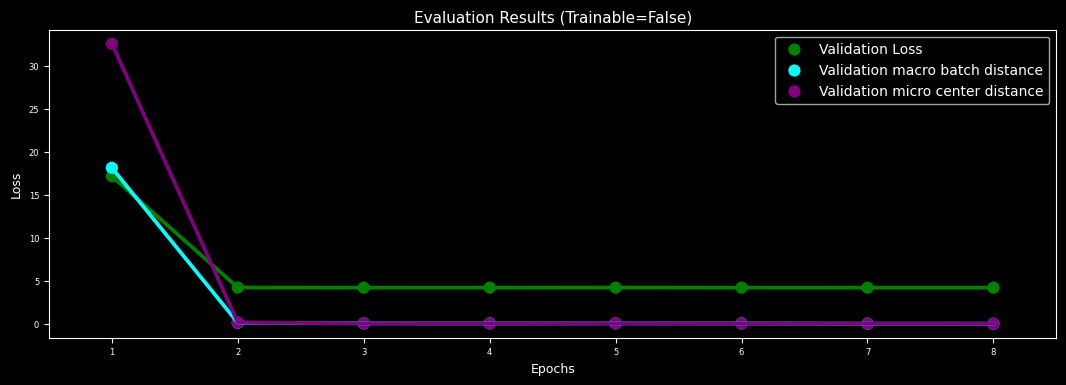

In [ ]:
epochs = list(range(1, 16))

fig, ax = plt.subplots(figsize=(13, 4))
# sns.pointplot(x=epochs, y=history.history['loss'], label="Train Loss", ax=ax, color='yellow')
sns.pointplot(x=epochs, y=history_center_loss.history['val_loss'], label="Validation Loss", ax=ax, color='green')
sns.pointplot(x=epochs, y=history_center_loss.history['val_dense_2_macro_batch_distance'], label="Validation macro batch distance", ax=ax, color='cyan')
sns.pointplot(x=epochs, y=history_center_loss.history['val_dense_2_micro_center_distance'], label="Validation micro center distance", ax=ax, color='purple')

ax.set_xlabel("Epochs", fontsize=9, color='white')
ax.set_ylabel("Loss", fontsize=9, color='white')
ax.set_title("Evaluation Results (Trainable=False)", fontsize=11, color='white')
ax.legend()

ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white', labelsize=6)
ax.tick_params(axis='y', colors='white', labelsize=6)
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')

ax.set_facecolor('black')
plt.style.use('dark_background')
ax.set_facecolor('#000000')
plt.show()

#### Continue Training

In [ ]:
# # # Base Model
# MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"

# input_layer = Input(shape=(224, 224, 3))
# x = hub.KerasLayer(MODEL_URL, trainable=True)(input_layer)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
# features = Dense(512, activation=None)(x)
# class_predictions = Dense(len(train_dataset.class_indices), activation='softmax')(features)

# # Creating a model with multiple outputs
# model =  tf.keras.Model(inputs=input_layer, outputs=[features, class_predictions])
# # Load the weights
# model.load_weights('/content/drive/MyDrive/V2_weights.h5')

In [ ]:
# # Base Model
# from tensorflow.keras.applications.resnet_v2 import ResNet152V2

# ResNet152V2 = ResNet152V2(weights='imagenet' , include_top=False)
# ResNet152V2.trainable=True
# # MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"

# input_layer = Input(shape=(384, 384, 3))
# # x = hub.KerasLayer(MODEL_URL, trainable=False)(input_layer)
# x = ResNet152V2(input_layer)
# x = GlobalAveragePooling2D()(x)
# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(1024, activation='relu')(x)
# features = Dense(1024, activation=None)(x)
# class_predictions = Dense(len(train_dataset.class_indices), activation='softmax')(features)

# # Creating a model with multiple outputs
# model =  tf.keras.Model(inputs=input_layer, outputs=[features, class_predictions])
# model.load_weights('/content/drive/MyDrive/Resnet50_weights_v0.h5')

In [ ]:
# model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                           

In [ ]:
# model.compile(optimizer=optimizers.RMSprop(learning_rate = 0.001),
#               loss=[center_loss_obj, losses.CategoricalCrossentropy()],
#               metrics=[micro_center_distance, macro_batch_distance])

# scheduler = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=3,
#                               min_lr=0.0001,
#                               verbose=1)

In [ ]:
# # First train for about 15 epochs
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     initial_epoch=15,
#     epochs=50,
#     batch_size=16,
#     callbacks=[scheduler]
# )

In [ ]:
# model.save_weights('/content/drive/MyDrive/ResNet152v2_final_weights.h5')

In [ ]:
# len(history.history['loss'])

20

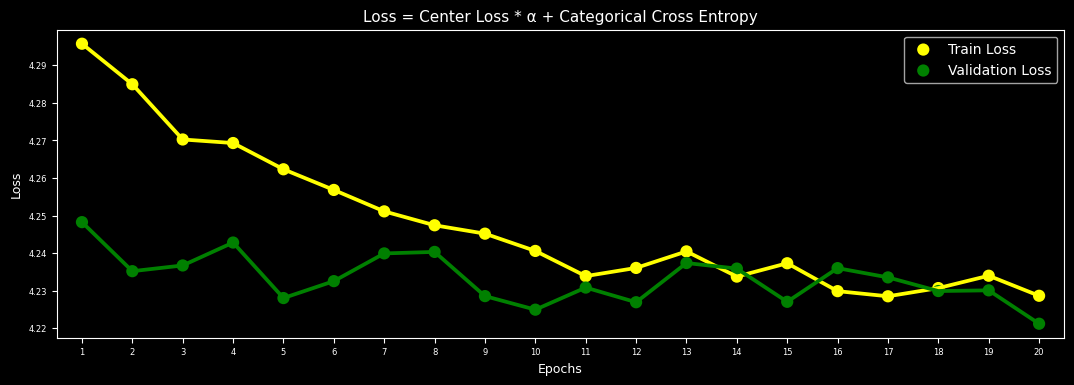

In [ ]:
# epochs = list(range(1, 21))

# fig, ax = plt.subplots(figsize=(13, 4))
# sns.pointplot(x=epochs, y=history.history['loss'], label="Train Loss", ax=ax, color='yellow')
# sns.pointplot(x=epochs, y=history.history['val_loss'], label="Validation Loss", ax=ax, color='green')

# ax.set_xlabel("Epochs", fontsize=9, color='white')
# ax.set_ylabel("Loss", fontsize=9, color='white')
# ax.set_title("Loss = Center Loss * α + Categorical Cross Entropy", fontsize=11, color='white')
# ax.legend()

# ax.spines['left'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.tick_params(axis='x', colors='white', labelsize=6)
# ax.tick_params(axis='y', colors='white', labelsize=6)
# ax.yaxis.label.set_color('white')
# ax.xaxis.label.set_color('white')

# ax.set_facecolor('black')
# plt.style.use('dark_background')
# plt.show()

# Evaluation

In [ ]:
# # # Base Model
# MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"

# input_layer = Input(shape=(224, 224, 3))
# x = hub.KerasLayer(MODEL_URL, trainable=True)(input_layer)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
# features = Dense(512, activation=None)(x)
# class_predictions = Dense(len(train_dataset.class_indices), activation='softmax')(features)

# # Creating a model with multiple outputs
# model =  tf.keras.Model(inputs=input_layer, outputs=[features, class_predictions])
# # Load the weights
# model.load_weights('/content/drive/MyDrive/final_weights.h5')

In [ ]:
# # # Base Model
# # MODEL_URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"
# ResNet152V2.trainable=True
# input_layer = Input(shape=(384, 384, 3))
# # x = hub.KerasLayer(MODEL_URL, trainable=False)(input_layer)
# x = ResNet152V2(input_layer)
# x = GlobalAveragePooling2D()(x)
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# x = Dense(1024, activation='relu')(x)
# features = Dense(1024, activation=None)(x)
# class_predictions = Dense(len(train_dataset.class_indices), activation='softmax')(features)

# # Creating a model with multiple outputs
# model =  tf.keras.Model(inputs=input_layer, outputs=[features, class_predictions])
# model.load_weights('/content/drive/MyDrive/ResNet152v2_final_weights.h5')

#### LFW like dataset Generator

In [ ]:
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("/content/drive/MyDrive/dataset/102flowers/test_df.csv")
df

,Unnamed: 0,Paths,label
0,597,/content/drive/MyDrive/dataset/102flowers/jpg/...,89
1,598,/content/drive/MyDrive/dataset/102flowers/jpg/...,89
2,599,/content/drive/MyDrive/dataset/102flowers/jpg/...,89
3,600,/content/drive/MyDrive/dataset/102flowers/jpg/...,89
4,601,/content/drive/MyDrive/dataset/102flowers/jpg/...,89
...,...,...,...
1986,8184,/content/drive/MyDrive/dataset/102flowers/jpg/...,62
1987,8185,/content/drive/MyDrive/dataset/102flowers/jpg/...,62
1988,8186,/content/drive/MyDrive/dataset/102flowers/jpg/...,62
1989,8187,/content/drive/MyDrive/dataset/102flowers/jpg/...,62


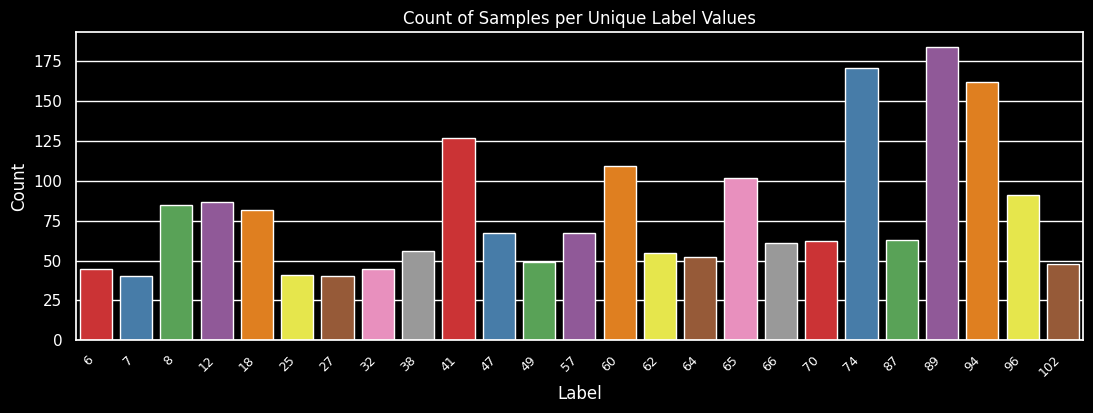

In [ ]:
# Create the countplot with Seaborn
plt.figure(figsize=(13, 4))
ax = sns.countplot(data=df, x='label', palette="Set1")

ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Count of Samples per Unique Label Values")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=9)

ax.set_facecolor('black')
plt.style.use('dark_background')
# plt.tight_layout()
plt.show()

In [ ]:
new_columns = ["Image_1_path", "Image_2_path", "Same"]
new_df = pd.DataFrame(columns=new_columns)
unique_labels = df["label"].unique()

# Loop through unique labels
for label in tqdm(unique_labels):
    same_label_rows = df[df["label"] == label]
    different_label_rows = df[df["label"] != label]

    # Get combinations of 32 same label rows
    same_label_combinations = list(combinations(same_label_rows.iterrows(), 2))
    same_label_combinations = random.sample(same_label_combinations, 32)

    # Get combinations of 32 different label rows
    different_label_combinations = list(combinations(different_label_rows.iterrows(), 2))
    different_label_combinations = random.sample(same_label_combinations, 32)

    for (index1, row1), (index2, row2) in same_label_combinations:
        new_df = new_df.append({
            "Image_1_path": row1["Paths"],
            "Image_2_path": row2["Paths"],
            "Same": 1
        }, ignore_index=True)

    for (index1, row1), (index2, row2) in different_label_combinations:
        new_df = new_df.append({
            "Image_1_path": row1["Paths"],
            "Image_2_path": row2["Paths"],
            "Same": 0
        }, ignore_index=True)

# Shuffle the new DataFrame
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df

100%|██████████| 25/25 [01:00<00:00,  2.43s/it]


,Image_1_path,Image_2_path,Same
0,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
1,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
2,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
3,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,1
4,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
...,...,...,...
1595,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
1596,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
1597,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,0
1598,/content/drive/MyDrive/dataset/102flowers/jpg/...,/content/drive/MyDrive/dataset/102flowers/jpg/...,1


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [ ]:
# Load the centerloss trained model but without head
feature_model = tf.keras.models.Model(inputs=model.inputs,
                                      outputs=model.get_layer('dense_2').output)

In [ ]:
new_df['Same'] = new_df['Same'].astype(bool)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image_1_path  1600 non-null   object
 1   Image_2_path  1600 non-null   object
 2   Same          1600 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 26.7+ KB


In [ ]:
def preproces_img(path, size):
    shape = (size,size)
    img = np.array(Image.open(path).resize(shape))
    img_array = np.expand_dims(img, axis=0)

    return img_array

In [ ]:
# These lines are just for further evalution
TP = 0
FP = 0
FN = 0
TN = 0
threshold = 0.50
truths = []
preds = []
sim_scores = []


# access each image column per row
for row in tqdm(range(len(new_df))):
    img_1_path = new_df['Image_1_path'].loc[row]
    img_2_path = new_df['Image_2_path'].loc[row]
    # Extract Features Per Each Pair of images
    img_1 = preproces_img(img_1_path, 224)
    img_2 = preproces_img(img_2_path, 224)
    feature_1 = feature_model.predict(img_1)
    feature_2 = feature_model.predict(img_2)

    """Here we need to calculate the Simmilarity"""
    sim = cosine_similarity(feature_1, feature_2)[0][0]
    pred = bool(sim > threshold)
    truth = new_df['Same'].loc[row]

    # Capture
    sim_scores.append(sim)
    preds.append(pred)
    truths.append(truth)

    """Evaluation"""
    # if (pred) and (pred == truth):
    if pred == truth:
        if pred:  # 1:1 Predicted correctly as same class
            TP+=1
        else:     # 0:0 Predicted correctly as different class
            TN+=1

    # if (not pred) and (pred == truth):
    if pred != truth:
        if pred: # 1:0 Predicted falsly as 1 while it was a 0
            FP+=1
        else:    # 0:1 Predicted falsly as 0 while it was a 1
            FN+=1


precision = TP/(TP+FP)
recall = TP/(TP+FN)
f_1 = 2*(precision*recall)/(precision+recall)
roc_auc = roc_auc_score(truths, sim_scores)

print(f"From Total {len(new_df)} images, the model performed:\nTrue Postives: {TP}\nFalse Postives: {FP}\nFalse Negatives: {FN}\nTrue Negatives: {TN}")
print(f"precision:{precision}\n recall:{recall}\n f1-score:{f_1}\n AUC:{roc_auc}")



  0%|          | 0/1600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 1/1600 [00:00<06:25,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 2/1600 [00:00<05:22,  4.96it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 3/1600 [00:00<05:04,  5.24it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 4/1600 [00:00<04:50,  5.49it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 5/1600 [00:00<05:04,  5.24it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 6/1600 [00:01<05:49,  4.57it/s]

1/1 [==============================] - 0s 47ms/step


  0%|          | 7/1600 [00:01<06:31,  4.07it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 8/1600 [00:01<06:13,  4.26it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 9/1600 [00:01<06:05,  4.35it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 10/1600 [00:02<06:11,  4.28it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 11/1600 [00:02<06:30,  4.07it/s]

1/1 [==============================] - 0s 53ms/step


  1%|          | 12/1600 [00:02<06:41,  3.96it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 13/1600 [00:03<07:21,  3.60it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 14/1600 [00:03<06:57,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 15/1600 [00:03<06:40,  3.96it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 16/1600 [00:03<06:46,  3.89it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 17/1600 [00:04<06:35,  4.00it/s]

1/1 [==============================] - 0s 50ms/step


  1%|          | 18/1600 [00:04<06:26,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 19/1600 [00:04<06:07,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 20/1600 [00:04<05:29,  4.79it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 21/1600 [00:04<05:12,  5.05it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 22/1600 [00:04<04:54,  5.35it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 23/1600 [00:05<04:44,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 24/1600 [00:05<04:34,  5.74it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 25/1600 [00:05<04:34,  5.73it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 26/1600 [00:05<04:27,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 27/1600 [00:05<04:23,  5.98it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 28/1600 [00:05<04:23,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 29/1600 [00:06<04:21,  6.01it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 30/1600 [00:06<04:19,  6.05it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 31/1600 [00:06<04:16,  6.13it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 32/1600 [00:06<04:16,  6.12it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 33/1600 [00:06<04:13,  6.18it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 34/1600 [00:06<04:18,  6.06it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 35/1600 [00:07<04:15,  6.13it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 36/1600 [00:07<04:21,  5.98it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 37/1600 [00:07<04:36,  5.65it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 38/1600 [00:07<04:29,  5.79it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 39/1600 [00:07<04:28,  5.82it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▎         | 40/1600 [00:07<04:22,  5.95it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 41/1600 [00:08<04:38,  5.59it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 42/1600 [00:08<04:32,  5.71it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 43/1600 [00:08<04:47,  5.41it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 44/1600 [00:08<04:56,  5.26it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 45/1600 [00:08<04:37,  5.59it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 46/1600 [00:09<04:27,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 47/1600 [00:09<04:27,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 48/1600 [00:09<04:22,  5.90it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 49/1600 [00:09<04:17,  6.02it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 50/1600 [00:09<04:15,  6.06it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 51/1600 [00:09<04:09,  6.20it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 52/1600 [00:10<04:13,  6.10it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 53/1600 [00:10<04:17,  6.01it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 54/1600 [00:10<04:13,  6.10it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 55/1600 [00:10<04:11,  6.14it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 56/1600 [00:10<04:12,  6.12it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 57/1600 [00:11<11:39,  2.20it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▎         | 58/1600 [00:12<10:14,  2.51it/s]

1/1 [==============================] - 0s 53ms/step


  4%|▎         | 59/1600 [00:12<09:22,  2.74it/s]

1/1 [==============================] - 0s 52ms/step


  4%|▍         | 60/1600 [00:12<08:41,  2.95it/s]

1/1 [==============================] - 0s 315ms/step


  4%|▍         | 61/1600 [00:13<11:49,  2.17it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▍         | 62/1600 [00:14<15:43,  1.63it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 63/1600 [00:14<15:09,  1.69it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 64/1600 [00:15<12:33,  2.04it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 65/1600 [00:15<10:53,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 66/1600 [00:15<10:12,  2.51it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 67/1600 [00:16<09:15,  2.76it/s]

1/1 [==============================] - 0s 57ms/step


  4%|▍         | 68/1600 [00:16<08:40,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


  4%|▍         | 69/1600 [00:16<08:03,  3.17it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 70/1600 [00:16<07:41,  3.32it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 71/1600 [00:17<07:45,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 72/1600 [00:17<08:01,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 73/1600 [00:17<07:25,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 74/1600 [00:17<06:39,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 75/1600 [00:18<06:26,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 76/1600 [00:18<06:13,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 77/1600 [00:18<05:46,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 78/1600 [00:18<05:28,  4.64it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 79/1600 [00:18<05:19,  4.75it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 80/1600 [00:19<05:05,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 81/1600 [00:19<05:16,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 82/1600 [00:19<05:02,  5.02it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 83/1600 [00:19<05:07,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 84/1600 [00:19<05:01,  5.04it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 85/1600 [00:20<05:12,  4.85it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 86/1600 [00:20<05:24,  4.66it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▌         | 87/1600 [00:20<05:20,  4.72it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▌         | 88/1600 [00:20<05:27,  4.61it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 89/1600 [00:21<05:16,  4.78it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 90/1600 [00:21<05:22,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 91/1600 [00:21<05:09,  4.88it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 92/1600 [00:21<05:09,  4.88it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 93/1600 [00:21<05:16,  4.76it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 94/1600 [00:22<05:12,  4.82it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 95/1600 [00:22<05:40,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 96/1600 [00:22<05:28,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 97/1600 [00:22<05:17,  4.73it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 98/1600 [00:22<05:07,  4.88it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 99/1600 [00:23<04:57,  5.05it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 100/1600 [00:23<04:51,  5.15it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 101/1600 [00:23<04:53,  5.10it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 102/1600 [00:23<04:53,  5.11it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 103/1600 [00:23<04:46,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▋         | 104/1600 [00:24<04:54,  5.09it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 105/1600 [00:24<04:54,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 106/1600 [00:24<04:50,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 107/1600 [00:24<04:45,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 108/1600 [00:24<04:47,  5.19it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 109/1600 [00:25<05:01,  4.95it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 110/1600 [00:25<05:15,  4.72it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 111/1600 [00:25<05:04,  4.89it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 112/1600 [00:25<05:00,  4.95it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 113/1600 [00:25<04:55,  5.03it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 114/1600 [00:26<04:56,  5.01it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 115/1600 [00:26<05:13,  4.73it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 116/1600 [00:26<05:20,  4.63it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 117/1600 [00:26<05:10,  4.77it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 118/1600 [00:26<05:22,  4.60it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 119/1600 [00:27<05:15,  4.69it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 120/1600 [00:27<05:24,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 121/1600 [00:27<05:10,  4.77it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 122/1600 [00:27<05:31,  4.46it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 123/1600 [00:28<06:23,  3.85it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 124/1600 [00:28<06:21,  3.87it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 125/1600 [00:28<06:34,  3.74it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 126/1600 [00:29<06:37,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 127/1600 [00:29<06:47,  3.61it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 128/1600 [00:29<06:56,  3.54it/s]

1/1 [==============================] - 0s 59ms/step


  8%|▊         | 129/1600 [00:29<07:06,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 130/1600 [00:30<06:51,  3.57it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 131/1600 [00:30<06:57,  3.52it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 132/1600 [00:30<07:21,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 133/1600 [00:31<07:04,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 134/1600 [00:31<06:46,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 135/1600 [00:31<06:08,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 136/1600 [00:31<06:13,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


  9%|▊         | 137/1600 [00:32<05:58,  4.08it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▊         | 138/1600 [00:32<05:43,  4.26it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▊         | 139/1600 [00:32<05:32,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 140/1600 [00:32<05:21,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 141/1600 [00:32<05:29,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 142/1600 [00:33<05:15,  4.63it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 143/1600 [00:33<05:05,  4.77it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 144/1600 [00:33<05:29,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 145/1600 [00:33<05:19,  4.55it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 146/1600 [00:33<05:07,  4.74it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 147/1600 [00:34<05:03,  4.79it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 148/1600 [00:34<05:11,  4.66it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 149/1600 [00:34<04:56,  4.89it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 150/1600 [00:34<04:52,  4.96it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 151/1600 [00:34<04:46,  5.06it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 152/1600 [00:35<04:44,  5.08it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 153/1600 [00:35<04:53,  4.92it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 154/1600 [00:35<05:05,  4.73it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 155/1600 [00:35<04:53,  4.92it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 156/1600 [00:35<04:45,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 157/1600 [00:36<04:37,  5.20it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 158/1600 [00:36<04:32,  5.29it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 159/1600 [00:36<04:28,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 160/1600 [00:36<04:23,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 161/1600 [00:36<04:16,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 162/1600 [00:36<04:11,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 163/1600 [00:37<04:23,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 164/1600 [00:37<04:18,  5.56it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 165/1600 [00:37<04:30,  5.30it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 166/1600 [00:37<04:37,  5.17it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 167/1600 [00:37<04:31,  5.29it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 168/1600 [00:38<04:27,  5.35it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 169/1600 [00:38<04:18,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 170/1600 [00:38<04:10,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 171/1600 [00:38<04:23,  5.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 172/1600 [00:38<04:20,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 173/1600 [00:39<04:15,  5.58it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 174/1600 [00:39<04:14,  5.59it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 175/1600 [00:39<04:23,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 176/1600 [00:39<04:35,  5.17it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 177/1600 [00:39<04:23,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 178/1600 [00:39<04:14,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 179/1600 [00:40<04:30,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 180/1600 [00:40<04:20,  5.44it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 181/1600 [00:40<04:17,  5.51it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 182/1600 [00:40<04:08,  5.70it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 183/1600 [00:40<04:21,  5.41it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 184/1600 [00:41<04:12,  5.61it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 185/1600 [00:41<04:46,  4.94it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 186/1600 [00:41<04:54,  4.80it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 187/1600 [00:41<05:07,  4.60it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 188/1600 [00:41<05:14,  4.48it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 189/1600 [00:42<05:37,  4.19it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 190/1600 [00:42<05:55,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 191/1600 [00:42<05:50,  4.02it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 192/1600 [00:43<05:38,  4.15it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 193/1600 [00:43<05:46,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 194/1600 [00:43<05:48,  4.03it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 195/1600 [00:43<05:37,  4.17it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 196/1600 [00:43<05:45,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 197/1600 [00:44<05:50,  4.00it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 198/1600 [00:44<05:49,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 199/1600 [00:44<05:21,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▎        | 200/1600 [00:44<04:55,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 201/1600 [00:45<04:33,  5.11it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 202/1600 [00:45<04:19,  5.40it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 203/1600 [00:45<04:30,  5.16it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 204/1600 [00:45<04:22,  5.31it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 205/1600 [00:45<04:28,  5.19it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 206/1600 [00:45<04:20,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 207/1600 [00:46<04:16,  5.43it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 208/1600 [00:46<04:11,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 209/1600 [00:46<04:05,  5.66it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 210/1600 [00:46<04:02,  5.73it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 211/1600 [00:46<04:00,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 212/1600 [00:46<04:02,  5.72it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 213/1600 [00:47<03:58,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 214/1600 [00:47<03:54,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 215/1600 [00:47<03:54,  5.92it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 216/1600 [00:47<04:09,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 217/1600 [00:47<04:04,  5.65it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 218/1600 [00:48<04:05,  5.63it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 219/1600 [00:48<04:24,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 220/1600 [00:48<04:24,  5.22it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 221/1600 [00:48<04:38,  4.95it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 222/1600 [00:48<04:30,  5.09it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 223/1600 [00:49<04:22,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 224/1600 [00:49<04:20,  5.29it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 225/1600 [00:49<04:24,  5.20it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 226/1600 [00:49<04:31,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 227/1600 [00:49<04:33,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 228/1600 [00:50<04:35,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 229/1600 [00:50<04:23,  5.20it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 230/1600 [00:50<04:19,  5.27it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 231/1600 [00:50<04:09,  5.48it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 232/1600 [00:50<04:03,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 233/1600 [00:50<03:57,  5.75it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 234/1600 [00:51<04:00,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 235/1600 [00:51<04:28,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 236/1600 [00:51<04:18,  5.27it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 237/1600 [00:51<04:22,  5.19it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 238/1600 [00:51<04:10,  5.44it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 239/1600 [00:52<04:22,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 240/1600 [00:52<04:30,  5.02it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 241/1600 [00:52<04:16,  5.29it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 242/1600 [00:52<04:08,  5.46it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 243/1600 [00:52<04:08,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 244/1600 [00:52<04:00,  5.65it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 245/1600 [00:53<03:56,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 246/1600 [00:53<03:55,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 247/1600 [00:53<03:53,  5.79it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 248/1600 [00:53<03:54,  5.77it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 249/1600 [00:53<04:05,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 250/1600 [00:54<04:15,  5.27it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 251/1600 [00:54<04:25,  5.08it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 252/1600 [00:54<04:18,  5.21it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 253/1600 [00:54<04:23,  5.11it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 254/1600 [00:54<04:39,  4.82it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 255/1600 [00:55<05:19,  4.21it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 256/1600 [00:55<05:46,  3.88it/s]

1/1 [==============================] - 0s 53ms/step


 16%|█▌        | 257/1600 [00:55<05:55,  3.78it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 258/1600 [00:56<05:58,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 259/1600 [00:56<05:49,  3.84it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▋        | 260/1600 [00:56<05:54,  3.78it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 261/1600 [00:56<05:56,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 16%|█▋        | 262/1600 [00:57<05:49,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 263/1600 [00:57<05:48,  3.84it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 264/1600 [00:57<05:29,  4.06it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 265/1600 [00:57<05:42,  3.90it/s]

1/1 [==============================] - 0s 46ms/step


 17%|█▋        | 266/1600 [00:58<05:38,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 267/1600 [00:58<05:02,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 268/1600 [00:58<04:38,  4.78it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 269/1600 [00:58<04:22,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 270/1600 [00:58<04:16,  5.18it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 271/1600 [00:58<04:07,  5.38it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 272/1600 [00:59<03:59,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 273/1600 [00:59<03:55,  5.64it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 274/1600 [00:59<03:57,  5.58it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 275/1600 [00:59<03:54,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 276/1600 [00:59<04:06,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 277/1600 [01:00<04:00,  5.51it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 278/1600 [01:00<03:57,  5.56it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 279/1600 [01:00<03:57,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 280/1600 [01:00<03:50,  5.72it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 281/1600 [01:00<03:54,  5.61it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 282/1600 [01:00<03:50,  5.72it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 283/1600 [01:01<03:49,  5.75it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 284/1600 [01:01<03:46,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 285/1600 [01:01<03:58,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 286/1600 [01:01<03:52,  5.65it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 287/1600 [01:01<03:51,  5.68it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 288/1600 [01:01<03:50,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 289/1600 [01:02<03:48,  5.74it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 290/1600 [01:02<03:46,  5.77it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 291/1600 [01:02<03:44,  5.83it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 292/1600 [01:02<04:00,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 293/1600 [01:02<03:58,  5.47it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 294/1600 [01:03<03:58,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 295/1600 [01:03<03:53,  5.59it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 296/1600 [01:03<03:47,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 297/1600 [01:03<04:04,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▊        | 298/1600 [01:03<04:01,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 299/1600 [01:03<03:53,  5.57it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 300/1600 [01:04<03:44,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 301/1600 [01:04<03:43,  5.81it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 302/1600 [01:04<03:45,  5.77it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 303/1600 [01:04<03:46,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 304/1600 [01:04<03:59,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 305/1600 [01:04<03:50,  5.62it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 306/1600 [01:05<03:50,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 307/1600 [01:05<03:48,  5.67it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 308/1600 [01:05<03:46,  5.70it/s]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 309/1600 [01:05<04:02,  5.33it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 310/1600 [01:05<03:58,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 311/1600 [01:06<03:51,  5.56it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 312/1600 [01:06<04:03,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 313/1600 [01:06<03:53,  5.52it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 314/1600 [01:06<03:50,  5.59it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 315/1600 [01:06<03:51,  5.56it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 316/1600 [01:06<03:48,  5.63it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 317/1600 [01:07<03:58,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 318/1600 [01:07<03:48,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 319/1600 [01:07<03:50,  5.57it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 320/1600 [01:07<03:44,  5.71it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 321/1600 [01:07<03:44,  5.70it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 322/1600 [01:08<03:41,  5.77it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 323/1600 [01:08<04:06,  5.18it/s]

1/1 [==============================] - 0s 47ms/step


 20%|██        | 324/1600 [01:08<04:30,  4.72it/s]

1/1 [==============================] - 0s 58ms/step


 20%|██        | 325/1600 [01:08<04:41,  4.53it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 326/1600 [01:09<04:51,  4.38it/s]

1/1 [==============================] - 0s 51ms/step


 20%|██        | 327/1600 [01:09<05:10,  4.09it/s]

1/1 [==============================] - 0s 49ms/step


 20%|██        | 328/1600 [01:09<05:30,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 329/1600 [01:09<05:18,  3.99it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 330/1600 [01:10<05:16,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 331/1600 [01:10<05:28,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 332/1600 [01:10<05:18,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 333/1600 [01:10<05:34,  3.79it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 334/1600 [01:11<05:27,  3.86it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 335/1600 [01:11<05:33,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 336/1600 [01:11<05:25,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 337/1600 [01:11<04:50,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 338/1600 [01:12<04:37,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 339/1600 [01:12<04:16,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 340/1600 [01:12<04:03,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██▏       | 341/1600 [01:12<03:56,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 342/1600 [01:12<03:50,  5.47it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██▏       | 343/1600 [01:12<03:47,  5.54it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 344/1600 [01:13<03:55,  5.34it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 345/1600 [01:13<03:53,  5.37it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 346/1600 [01:13<03:51,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 347/1600 [01:13<04:01,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 348/1600 [01:13<03:49,  5.45it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 349/1600 [01:13<03:46,  5.53it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 350/1600 [01:14<03:46,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 351/1600 [01:14<03:44,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 352/1600 [01:14<03:38,  5.70it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 353/1600 [01:14<03:34,  5.82it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 354/1600 [01:14<03:32,  5.87it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 355/1600 [01:15<03:37,  5.71it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 356/1600 [01:15<03:53,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 357/1600 [01:15<03:46,  5.50it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 358/1600 [01:15<03:39,  5.65it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 359/1600 [01:15<03:40,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▎       | 360/1600 [01:15<03:38,  5.68it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 361/1600 [01:16<03:57,  5.23it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 362/1600 [01:16<03:49,  5.38it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 363/1600 [01:16<03:44,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 364/1600 [01:16<03:57,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 365/1600 [01:16<03:44,  5.51it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 366/1600 [01:17<03:43,  5.53it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 367/1600 [01:17<03:55,  5.23it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 368/1600 [01:17<04:02,  5.08it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 369/1600 [01:17<03:49,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 370/1600 [01:17<03:40,  5.57it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 371/1600 [01:17<03:38,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 372/1600 [01:18<03:56,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 373/1600 [01:18<03:47,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 374/1600 [01:18<03:40,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 375/1600 [01:18<03:35,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 376/1600 [01:18<03:35,  5.67it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 377/1600 [01:19<03:38,  5.61it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 378/1600 [01:19<03:38,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 379/1600 [01:19<03:31,  5.76it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 380/1600 [01:19<03:28,  5.85it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 381/1600 [01:19<03:30,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 382/1600 [01:19<03:45,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 383/1600 [01:20<03:40,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 384/1600 [01:20<03:41,  5.49it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 385/1600 [01:20<03:50,  5.26it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 386/1600 [01:20<03:49,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 387/1600 [01:20<03:45,  5.38it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 388/1600 [01:21<03:53,  5.20it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 389/1600 [01:21<04:03,  4.98it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 390/1600 [01:21<04:06,  4.91it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 391/1600 [01:21<04:03,  4.97it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 392/1600 [01:21<04:15,  4.72it/s]

1/1 [==============================] - 0s 74ms/step


 25%|██▍       | 393/1600 [01:22<04:45,  4.22it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 394/1600 [01:22<04:45,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 395/1600 [01:22<04:58,  4.04it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 396/1600 [01:23<04:57,  4.04it/s]

1/1 [==============================] - 0s 59ms/step


 25%|██▍       | 397/1600 [01:23<05:08,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 398/1600 [01:23<05:01,  3.99it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 399/1600 [01:23<04:59,  4.01it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 400/1600 [01:24<05:01,  3.98it/s]

1/1 [==============================] - 0s 71ms/step


 25%|██▌       | 401/1600 [01:24<05:14,  3.81it/s]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 402/1600 [01:24<05:10,  3.86it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▌       | 403/1600 [01:24<05:18,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 404/1600 [01:25<05:12,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 405/1600 [01:25<05:04,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 406/1600 [01:25<04:37,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 407/1600 [01:25<04:12,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 408/1600 [01:25<04:01,  4.93it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 409/1600 [01:26<04:18,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 410/1600 [01:26<04:01,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 411/1600 [01:26<03:59,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 412/1600 [01:26<03:49,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 413/1600 [01:26<03:46,  5.24it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 414/1600 [01:27<03:40,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 415/1600 [01:27<03:34,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 416/1600 [01:27<03:46,  5.22it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 417/1600 [01:27<03:42,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 418/1600 [01:27<03:34,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 419/1600 [01:27<03:30,  5.62it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 420/1600 [01:28<03:32,  5.55it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 421/1600 [01:28<03:46,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 422/1600 [01:28<03:42,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 423/1600 [01:28<03:36,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 424/1600 [01:28<03:59,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 425/1600 [01:29<03:57,  4.94it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 426/1600 [01:29<04:02,  4.85it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 427/1600 [01:29<03:51,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 428/1600 [01:29<03:55,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 429/1600 [01:29<03:45,  5.20it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 430/1600 [01:30<03:36,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 431/1600 [01:30<03:34,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 432/1600 [01:30<03:29,  5.57it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 433/1600 [01:30<03:31,  5.51it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 434/1600 [01:30<03:27,  5.62it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 435/1600 [01:30<03:28,  5.58it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 436/1600 [01:31<03:28,  5.59it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 437/1600 [01:31<03:46,  5.14it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 438/1600 [01:31<03:48,  5.09it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 439/1600 [01:31<03:58,  4.88it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 440/1600 [01:31<03:54,  4.94it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 441/1600 [01:32<03:53,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 442/1600 [01:32<03:48,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 443/1600 [01:32<03:48,  5.07it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 444/1600 [01:32<03:45,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 445/1600 [01:32<03:41,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 446/1600 [01:33<03:36,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 447/1600 [01:33<04:02,  4.75it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 448/1600 [01:33<03:55,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 449/1600 [01:33<04:10,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 450/1600 [01:33<03:53,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 451/1600 [01:34<03:42,  5.16it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 452/1600 [01:34<03:44,  5.12it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 453/1600 [01:34<03:42,  5.16it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 454/1600 [01:34<03:40,  5.19it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 455/1600 [01:34<03:30,  5.43it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 456/1600 [01:35<03:52,  4.91it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 457/1600 [01:35<03:53,  4.90it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 458/1600 [01:35<04:14,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▊       | 459/1600 [01:35<04:24,  4.31it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 460/1600 [01:36<04:29,  4.23it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 461/1600 [01:36<04:37,  4.11it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▉       | 462/1600 [01:36<04:47,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 463/1600 [01:36<04:59,  3.79it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▉       | 464/1600 [01:37<05:13,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 465/1600 [01:37<05:00,  3.78it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 466/1600 [01:37<05:02,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 467/1600 [01:38<05:13,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 468/1600 [01:38<05:14,  3.60it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 469/1600 [01:38<05:13,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 470/1600 [01:38<05:07,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 471/1600 [01:39<04:47,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 472/1600 [01:39<04:33,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 473/1600 [01:39<04:06,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 474/1600 [01:39<03:54,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 475/1600 [01:39<03:49,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 476/1600 [01:40<03:42,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 477/1600 [01:40<03:39,  5.12it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 478/1600 [01:40<03:48,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 479/1600 [01:40<03:41,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 480/1600 [01:40<03:40,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 481/1600 [01:41<03:34,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 482/1600 [01:41<03:49,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 483/1600 [01:41<03:40,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 484/1600 [01:41<03:37,  5.14it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 485/1600 [01:41<03:36,  5.14it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 486/1600 [01:41<03:33,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 487/1600 [01:42<03:31,  5.26it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 488/1600 [01:42<03:26,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 489/1600 [01:42<03:31,  5.24it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 490/1600 [01:42<03:42,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 491/1600 [01:42<03:37,  5.09it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 492/1600 [01:43<03:33,  5.20it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 493/1600 [01:43<03:31,  5.23it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 494/1600 [01:43<03:40,  5.02it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 495/1600 [01:43<03:50,  4.80it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 496/1600 [01:44<03:56,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 497/1600 [01:44<03:45,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 498/1600 [01:44<03:51,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 499/1600 [01:44<03:37,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 500/1600 [01:44<03:30,  5.22it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 501/1600 [01:44<03:30,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 502/1600 [01:45<03:24,  5.36it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 503/1600 [01:45<03:20,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 504/1600 [01:45<03:21,  5.44it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 505/1600 [01:45<03:14,  5.62it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 506/1600 [01:45<03:19,  5.49it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 507/1600 [01:46<03:22,  5.41it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 508/1600 [01:46<03:22,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 509/1600 [01:46<03:18,  5.49it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 510/1600 [01:46<03:18,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 511/1600 [01:46<03:18,  5.49it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 512/1600 [01:46<03:18,  5.48it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 513/1600 [01:47<03:30,  5.17it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 514/1600 [01:47<03:22,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 515/1600 [01:47<03:22,  5.36it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 516/1600 [01:47<03:31,  5.13it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 517/1600 [01:47<03:33,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 518/1600 [01:48<03:23,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 519/1600 [01:48<03:19,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▎      | 520/1600 [01:48<03:18,  5.43it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 521/1600 [01:48<03:18,  5.43it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 522/1600 [01:48<03:15,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 523/1600 [01:49<03:26,  5.22it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 524/1600 [01:49<03:38,  4.92it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 525/1600 [01:49<03:54,  4.58it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 526/1600 [01:49<04:05,  4.38it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 527/1600 [01:50<04:24,  4.06it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 528/1600 [01:50<04:29,  3.98it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 529/1600 [01:50<04:46,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 530/1600 [01:50<04:54,  3.63it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 531/1600 [01:51<04:44,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 532/1600 [01:51<04:30,  3.94it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 533/1600 [01:51<04:35,  3.88it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 534/1600 [01:51<04:36,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 535/1600 [01:52<04:43,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 536/1600 [01:52<04:52,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 537/1600 [01:52<04:41,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 538/1600 [01:52<04:13,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▎      | 539/1600 [01:53<03:56,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 540/1600 [01:53<03:42,  4.76it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 541/1600 [01:53<03:29,  5.06it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 542/1600 [01:53<03:34,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 543/1600 [01:53<03:23,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 544/1600 [01:54<03:19,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 545/1600 [01:54<03:15,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 546/1600 [01:54<03:17,  5.33it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 547/1600 [01:54<03:14,  5.42it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 548/1600 [01:54<03:13,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 549/1600 [01:54<03:22,  5.19it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 550/1600 [01:55<03:15,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 551/1600 [01:55<03:28,  5.03it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 552/1600 [01:55<03:21,  5.21it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 553/1600 [01:55<03:26,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 554/1600 [01:55<03:39,  4.76it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 555/1600 [01:56<03:34,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 556/1600 [01:56<03:25,  5.07it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 557/1600 [01:56<03:16,  5.32it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 558/1600 [01:56<03:13,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 559/1600 [01:56<03:10,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 560/1600 [01:57<03:21,  5.16it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 561/1600 [01:57<03:15,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 562/1600 [01:57<03:10,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 563/1600 [01:57<03:07,  5.53it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 564/1600 [01:57<03:06,  5.56it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 565/1600 [01:57<03:03,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 566/1600 [01:58<03:16,  5.27it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 567/1600 [01:58<03:13,  5.33it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 568/1600 [01:58<03:09,  5.45it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 569/1600 [01:58<03:22,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 570/1600 [01:58<03:15,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 571/1600 [01:59<03:12,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 572/1600 [01:59<03:15,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 573/1600 [01:59<03:11,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 574/1600 [01:59<03:08,  5.44it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 575/1600 [01:59<03:02,  5.62it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 576/1600 [02:00<03:00,  5.69it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 577/1600 [02:00<03:03,  5.58it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 578/1600 [02:00<04:12,  4.04it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 579/1600 [02:01<05:50,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 580/1600 [02:01<05:57,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 581/1600 [02:01<05:08,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 582/1600 [02:01<04:34,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 583/1600 [02:02<04:25,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▋      | 584/1600 [02:02<04:03,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 585/1600 [02:02<03:56,  4.29it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 586/1600 [02:02<03:42,  4.55it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 587/1600 [02:03<03:57,  4.27it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 588/1600 [02:03<04:12,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 589/1600 [02:03<04:26,  3.80it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 590/1600 [02:03<04:31,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 591/1600 [02:04<04:20,  3.87it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 592/1600 [02:04<04:22,  3.84it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 593/1600 [02:04<04:31,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 594/1600 [02:04<04:28,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 595/1600 [02:05<04:34,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 596/1600 [02:05<04:44,  3.53it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 597/1600 [02:05<04:31,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 598/1600 [02:05<04:15,  3.92it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 599/1600 [02:06<04:10,  3.99it/s]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 600/1600 [02:06<04:20,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 601/1600 [02:06<04:09,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 602/1600 [02:06<03:46,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 603/1600 [02:07<03:28,  4.78it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 604/1600 [02:07<03:19,  5.00it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 605/1600 [02:07<03:14,  5.11it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 606/1600 [02:07<03:11,  5.19it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 607/1600 [02:07<03:08,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 608/1600 [02:07<03:02,  5.44it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 609/1600 [02:08<03:13,  5.11it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 610/1600 [02:08<03:07,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 611/1600 [02:08<03:04,  5.35it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 612/1600 [02:08<03:04,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 613/1600 [02:08<03:01,  5.42it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 614/1600 [02:09<02:58,  5.54it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 615/1600 [02:09<02:56,  5.59it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 616/1600 [02:09<02:53,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 617/1600 [02:09<02:58,  5.51it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 618/1600 [02:09<03:16,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 619/1600 [02:10<03:07,  5.23it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 620/1600 [02:10<03:14,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 621/1600 [02:10<03:27,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 622/1600 [02:10<03:21,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 623/1600 [02:10<03:12,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 624/1600 [02:11<03:26,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 625/1600 [02:11<03:13,  5.04it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 626/1600 [02:11<03:21,  4.84it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 627/1600 [02:11<03:13,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 628/1600 [02:11<03:04,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 629/1600 [02:12<03:12,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 630/1600 [02:12<03:15,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 631/1600 [02:12<03:07,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 632/1600 [02:12<03:14,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 633/1600 [02:12<03:02,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 634/1600 [02:13<02:57,  5.43it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 635/1600 [02:13<02:56,  5.46it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 636/1600 [02:13<02:54,  5.51it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 637/1600 [02:13<02:49,  5.69it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 638/1600 [02:13<02:51,  5.61it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 639/1600 [02:13<02:59,  5.36it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 640/1600 [02:14<03:12,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 641/1600 [02:14<03:09,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 642/1600 [02:14<03:13,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 643/1600 [02:14<03:06,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 644/1600 [02:15<03:25,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 645/1600 [02:15<03:12,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 646/1600 [02:15<03:08,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 647/1600 [02:15<03:02,  5.22it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 648/1600 [02:15<03:00,  5.26it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 649/1600 [02:15<03:02,  5.22it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 650/1600 [02:16<02:59,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 651/1600 [02:16<03:06,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 652/1600 [02:16<03:00,  5.26it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 653/1600 [02:16<03:21,  4.70it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████      | 654/1600 [02:17<03:30,  4.49it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 655/1600 [02:17<03:42,  4.24it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 656/1600 [02:17<03:56,  4.00it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 657/1600 [02:17<04:00,  3.93it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 658/1600 [02:18<04:06,  3.82it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 659/1600 [02:18<04:01,  3.90it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████▏     | 660/1600 [02:18<04:08,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████▏     | 661/1600 [02:18<04:05,  3.82it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 662/1600 [02:19<04:08,  3.78it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████▏     | 663/1600 [02:19<04:05,  3.82it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 664/1600 [02:19<04:09,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 665/1600 [02:19<04:16,  3.65it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 666/1600 [02:20<04:13,  3.68it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 667/1600 [02:20<04:23,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 668/1600 [02:20<03:51,  4.03it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 669/1600 [02:20<03:34,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 670/1600 [02:21<03:19,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 671/1600 [02:21<03:09,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 672/1600 [02:21<03:22,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 673/1600 [02:21<03:09,  4.88it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 674/1600 [02:21<03:01,  5.09it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 675/1600 [02:22<03:11,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 676/1600 [02:22<03:03,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 677/1600 [02:22<02:54,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 678/1600 [02:22<02:50,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 679/1600 [02:22<02:47,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▎     | 680/1600 [02:23<03:01,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 681/1600 [02:23<02:54,  5.25it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 682/1600 [02:23<02:51,  5.35it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 683/1600 [02:23<02:49,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 684/1600 [02:23<03:09,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 685/1600 [02:24<03:05,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 686/1600 [02:24<03:02,  5.02it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 687/1600 [02:24<03:12,  4.75it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 688/1600 [02:24<03:02,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 689/1600 [02:24<03:07,  4.85it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 690/1600 [02:25<03:03,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 691/1600 [02:25<02:55,  5.19it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 692/1600 [02:25<02:52,  5.27it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 693/1600 [02:25<02:51,  5.30it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 694/1600 [02:25<02:58,  5.08it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 695/1600 [02:25<02:54,  5.18it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 696/1600 [02:26<02:51,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 697/1600 [02:26<02:46,  5.42it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 698/1600 [02:26<02:55,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 699/1600 [02:26<02:53,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 700/1600 [02:26<02:57,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 701/1600 [02:27<02:54,  5.15it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 702/1600 [02:27<03:03,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 703/1600 [02:27<02:55,  5.11it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 704/1600 [02:27<02:53,  5.17it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 705/1600 [02:27<02:45,  5.41it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 706/1600 [02:28<02:46,  5.37it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 707/1600 [02:28<02:49,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 708/1600 [02:28<02:46,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 709/1600 [02:28<02:45,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 710/1600 [02:28<02:43,  5.46it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 711/1600 [02:29<02:45,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 712/1600 [02:29<02:52,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 713/1600 [02:29<02:49,  5.24it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 714/1600 [02:29<02:44,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 715/1600 [02:29<02:41,  5.47it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 716/1600 [02:29<02:54,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 717/1600 [02:30<02:53,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 718/1600 [02:30<02:44,  5.35it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 719/1600 [02:30<02:51,  5.15it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 720/1600 [02:30<03:20,  4.39it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 721/1600 [02:31<03:15,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 722/1600 [02:31<03:25,  4.27it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 723/1600 [02:31<03:24,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 724/1600 [02:31<03:40,  3.97it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▌     | 725/1600 [02:32<03:50,  3.80it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 726/1600 [02:32<04:00,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 727/1600 [02:32<04:05,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 728/1600 [02:33<04:10,  3.48it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 729/1600 [02:33<04:15,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 730/1600 [02:33<04:17,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 731/1600 [02:33<04:21,  3.32it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 732/1600 [02:34<04:07,  3.50it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████▌     | 733/1600 [02:34<04:12,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 734/1600 [02:34<04:11,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 735/1600 [02:35<04:17,  3.36it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 736/1600 [02:35<04:21,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 737/1600 [02:35<04:05,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 738/1600 [02:35<04:10,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 739/1600 [02:36<03:58,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 740/1600 [02:36<04:04,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▋     | 741/1600 [02:36<04:00,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▋     | 742/1600 [02:37<03:48,  3.75it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 743/1600 [02:37<03:51,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 744/1600 [02:37<03:56,  3.62it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 745/1600 [02:37<03:58,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 746/1600 [02:38<03:56,  3.62it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 747/1600 [02:38<03:45,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 748/1600 [02:38<03:29,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 749/1600 [02:38<03:30,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 750/1600 [02:39<03:09,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 751/1600 [02:39<02:59,  4.74it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 752/1600 [02:39<02:53,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 753/1600 [02:39<02:53,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 754/1600 [02:39<02:46,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 755/1600 [02:39<02:40,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 756/1600 [02:40<02:39,  5.28it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 757/1600 [02:40<02:54,  4.82it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 758/1600 [02:40<03:00,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 759/1600 [02:40<02:58,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 760/1600 [02:41<02:55,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 761/1600 [02:41<02:49,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 762/1600 [02:41<02:52,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 763/1600 [02:41<02:46,  5.02it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 764/1600 [02:41<02:44,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 765/1600 [02:42<02:43,  5.11it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 766/1600 [02:42<02:51,  4.87it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 767/1600 [02:42<02:42,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 768/1600 [02:42<02:39,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 769/1600 [02:42<02:36,  5.30it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 770/1600 [02:42<02:34,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 771/1600 [02:43<02:32,  5.44it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 772/1600 [02:43<02:33,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 773/1600 [02:43<02:31,  5.45it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 774/1600 [02:43<02:34,  5.34it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 775/1600 [02:43<02:32,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 776/1600 [02:44<02:40,  5.15it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 777/1600 [02:44<02:35,  5.31it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 778/1600 [02:44<02:32,  5.37it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▊     | 779/1600 [02:44<02:37,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 780/1600 [02:44<02:31,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 781/1600 [02:45<02:42,  5.05it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 782/1600 [02:45<02:35,  5.25it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 783/1600 [02:45<02:35,  5.24it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 784/1600 [02:45<02:53,  4.71it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 785/1600 [02:45<03:02,  4.46it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 786/1600 [02:46<03:16,  4.14it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 787/1600 [02:46<03:27,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 788/1600 [02:46<03:39,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 789/1600 [02:47<03:27,  3.91it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 790/1600 [02:47<03:24,  3.97it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 791/1600 [02:47<03:32,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 792/1600 [02:47<03:46,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 793/1600 [02:48<03:41,  3.65it/s]

1/1 [==============================] - 0s 54ms/step


 50%|████▉     | 794/1600 [02:48<03:40,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 795/1600 [02:48<03:54,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 796/1600 [02:48<03:45,  3.57it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 797/1600 [02:49<03:38,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 798/1600 [02:49<03:46,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 799/1600 [02:49<03:23,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 800/1600 [02:49<03:05,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 801/1600 [02:50<02:55,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 802/1600 [02:50<02:46,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 803/1600 [02:50<02:47,  4.77it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 804/1600 [02:50<02:42,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 805/1600 [02:50<02:49,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 806/1600 [02:51<02:50,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 807/1600 [02:51<02:52,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 808/1600 [02:51<02:42,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 809/1600 [02:51<02:36,  5.07it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 810/1600 [02:51<02:34,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 811/1600 [02:52<02:31,  5.21it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 812/1600 [02:52<02:25,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 813/1600 [02:52<02:33,  5.12it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 814/1600 [02:52<02:29,  5.26it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 815/1600 [02:52<02:27,  5.33it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 816/1600 [02:53<02:26,  5.34it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 817/1600 [02:53<02:23,  5.47it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 818/1600 [02:53<02:26,  5.33it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 819/1600 [02:53<02:33,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 820/1600 [02:53<02:27,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 821/1600 [02:53<02:26,  5.32it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 822/1600 [02:54<02:33,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 823/1600 [02:54<02:33,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 824/1600 [02:54<02:32,  5.10it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 825/1600 [02:54<02:28,  5.23it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 826/1600 [02:54<02:27,  5.23it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 827/1600 [02:55<02:24,  5.34it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 828/1600 [02:55<02:32,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 829/1600 [02:55<02:26,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 830/1600 [02:55<02:22,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 831/1600 [02:55<02:30,  5.10it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 832/1600 [02:56<02:32,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 833/1600 [02:56<02:27,  5.20it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 834/1600 [02:56<02:23,  5.34it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 835/1600 [02:56<02:22,  5.39it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 836/1600 [02:56<02:21,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 837/1600 [02:57<02:31,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 838/1600 [02:57<02:26,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 839/1600 [02:57<02:23,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▎    | 840/1600 [02:57<02:22,  5.33it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 841/1600 [02:57<02:32,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 842/1600 [02:58<02:34,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 843/1600 [02:58<02:27,  5.14it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 844/1600 [02:58<02:25,  5.19it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 845/1600 [02:58<02:23,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 846/1600 [02:58<02:22,  5.28it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 847/1600 [02:58<02:20,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 848/1600 [02:59<02:28,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 849/1600 [02:59<02:31,  4.96it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 850/1600 [02:59<02:48,  4.46it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 851/1600 [02:59<02:55,  4.27it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 852/1600 [03:00<02:56,  4.25it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 853/1600 [03:00<03:05,  4.03it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 854/1600 [03:00<03:19,  3.74it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 855/1600 [03:01<03:17,  3.78it/s]

1/1 [==============================] - 0s 65ms/step


 54%|█████▎    | 856/1600 [03:01<03:13,  3.84it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 857/1600 [03:01<03:18,  3.75it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 858/1600 [03:01<03:20,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 859/1600 [03:02<03:21,  3.68it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 860/1600 [03:02<03:33,  3.47it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 861/1600 [03:02<03:33,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 862/1600 [03:03<03:36,  3.40it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 863/1600 [03:03<03:36,  3.40it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 864/1600 [03:03<03:39,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 865/1600 [03:03<03:26,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 866/1600 [03:04<03:03,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 867/1600 [03:04<02:48,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 868/1600 [03:04<02:42,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 869/1600 [03:04<02:31,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 870/1600 [03:04<02:24,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 871/1600 [03:05<02:27,  4.94it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 872/1600 [03:05<02:22,  5.11it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 873/1600 [03:05<02:31,  4.80it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 874/1600 [03:05<02:22,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 875/1600 [03:05<02:20,  5.16it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 876/1600 [03:05<02:18,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 877/1600 [03:06<02:15,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 878/1600 [03:06<02:26,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 879/1600 [03:06<02:24,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 880/1600 [03:06<02:19,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 881/1600 [03:06<02:20,  5.13it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 882/1600 [03:07<02:15,  5.28it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 883/1600 [03:07<02:15,  5.28it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 884/1600 [03:07<02:15,  5.28it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 885/1600 [03:07<02:22,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 886/1600 [03:07<02:19,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 887/1600 [03:08<02:15,  5.24it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 888/1600 [03:08<02:14,  5.31it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 889/1600 [03:08<02:14,  5.30it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 890/1600 [03:08<02:13,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 891/1600 [03:08<02:17,  5.14it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 892/1600 [03:09<02:14,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 893/1600 [03:09<02:11,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 894/1600 [03:09<02:11,  5.36it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 895/1600 [03:09<02:14,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 896/1600 [03:09<02:12,  5.32it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 897/1600 [03:10<02:21,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 898/1600 [03:10<02:16,  5.14it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 899/1600 [03:10<02:22,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 900/1600 [03:10<02:28,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 901/1600 [03:10<02:26,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 902/1600 [03:11<02:20,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 903/1600 [03:11<02:17,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 904/1600 [03:11<02:14,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 905/1600 [03:11<02:13,  5.20it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 906/1600 [03:11<02:16,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 907/1600 [03:12<02:23,  4.83it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 908/1600 [03:12<02:18,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 909/1600 [03:12<02:23,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 910/1600 [03:12<02:19,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 911/1600 [03:12<02:15,  5.09it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 912/1600 [03:13<02:16,  5.05it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 913/1600 [03:13<02:13,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 914/1600 [03:13<02:11,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 915/1600 [03:13<02:08,  5.34it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 916/1600 [03:13<02:13,  5.11it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 917/1600 [03:14<02:30,  4.55it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 918/1600 [03:14<02:43,  4.17it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 919/1600 [03:14<02:41,  4.21it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▊    | 920/1600 [03:14<03:00,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 921/1600 [03:15<02:55,  3.87it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 922/1600 [03:15<03:02,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 923/1600 [03:15<02:57,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 924/1600 [03:15<03:00,  3.75it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 925/1600 [03:16<02:56,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 926/1600 [03:16<03:07,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 927/1600 [03:16<03:11,  3.52it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████▊    | 928/1600 [03:17<03:07,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 929/1600 [03:17<03:10,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 930/1600 [03:17<03:02,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 931/1600 [03:17<02:56,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 932/1600 [03:18<02:46,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 933/1600 [03:18<02:34,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 934/1600 [03:19<04:57,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 935/1600 [03:19<04:09,  2.67it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 936/1600 [03:19<03:36,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 937/1600 [03:19<03:14,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 938/1600 [03:20<02:56,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 939/1600 [03:20<02:49,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 940/1600 [03:20<02:38,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 941/1600 [03:20<02:38,  4.17it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 942/1600 [03:21<02:40,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 943/1600 [03:21<02:34,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 944/1600 [03:21<02:32,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 945/1600 [03:21<02:28,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 946/1600 [03:21<02:26,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 947/1600 [03:22<02:24,  4.52it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 948/1600 [03:22<02:25,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 949/1600 [03:22<02:20,  4.63it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 950/1600 [03:22<02:18,  4.68it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 951/1600 [03:22<02:26,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 952/1600 [03:23<02:22,  4.55it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 953/1600 [03:23<02:21,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 954/1600 [03:23<02:25,  4.42it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 955/1600 [03:23<02:29,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 956/1600 [03:24<02:34,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 957/1600 [03:24<02:34,  4.16it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 958/1600 [03:24<02:30,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 959/1600 [03:24<02:24,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 960/1600 [03:25<02:21,  4.53it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 961/1600 [03:25<02:36,  4.08it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 962/1600 [03:25<02:29,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 963/1600 [03:25<02:24,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 964/1600 [03:25<02:24,  4.40it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 965/1600 [03:26<02:25,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 966/1600 [03:26<02:22,  4.46it/s]

1/1 [==============================] - 0s 51ms/step


 60%|██████    | 967/1600 [03:26<02:18,  4.56it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 968/1600 [03:26<02:17,  4.61it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 969/1600 [03:27<02:15,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 970/1600 [03:27<02:21,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 971/1600 [03:27<02:19,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 972/1600 [03:27<02:16,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 973/1600 [03:27<02:12,  4.73it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████    | 974/1600 [03:28<02:37,  3.97it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 975/1600 [03:28<02:43,  3.83it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████    | 976/1600 [03:28<02:58,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 977/1600 [03:29<03:05,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 978/1600 [03:29<03:10,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 979/1600 [03:29<03:08,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████▏   | 980/1600 [03:30<03:18,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████▏   | 981/1600 [03:30<03:23,  3.05it/s]

1/1 [==============================] - 0s 56ms/step


 61%|██████▏   | 982/1600 [03:30<03:23,  3.03it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████▏   | 983/1600 [03:31<03:22,  3.05it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 984/1600 [03:31<03:21,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 985/1600 [03:31<03:04,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 986/1600 [03:31<02:47,  3.67it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 987/1600 [03:32<02:40,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 988/1600 [03:32<02:27,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 989/1600 [03:32<02:28,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 990/1600 [03:32<02:21,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 991/1600 [03:33<02:25,  4.20it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 992/1600 [03:33<02:33,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 993/1600 [03:33<02:29,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 994/1600 [03:33<02:24,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 995/1600 [03:34<02:22,  4.25it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 996/1600 [03:34<02:29,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 997/1600 [03:34<02:24,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 998/1600 [03:34<02:19,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 999/1600 [03:35<02:19,  4.31it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▎   | 1000/1600 [03:35<02:23,  4.17it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1001/1600 [03:35<02:19,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1002/1600 [03:35<02:17,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1003/1600 [03:35<02:15,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1004/1600 [03:36<02:12,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 1005/1600 [03:36<02:15,  4.39it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1006/1600 [03:36<02:11,  4.51it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1007/1600 [03:36<02:17,  4.32it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 1008/1600 [03:37<02:19,  4.25it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 1009/1600 [03:37<02:18,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1010/1600 [03:37<02:14,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1011/1600 [03:37<02:11,  4.46it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1012/1600 [03:37<02:09,  4.55it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 1013/1600 [03:38<02:07,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1014/1600 [03:38<02:09,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 1015/1600 [03:38<02:07,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 1016/1600 [03:38<02:18,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 1017/1600 [03:39<02:17,  4.23it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 1018/1600 [03:39<02:14,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 1019/1600 [03:39<02:11,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1020/1600 [03:39<02:05,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 1021/1600 [03:39<02:03,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 1022/1600 [03:40<02:00,  4.79it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1023/1600 [03:40<02:00,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 1024/1600 [03:40<01:58,  4.87it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 1025/1600 [03:40<02:03,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 1026/1600 [03:41<01:57,  4.87it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1027/1600 [03:41<01:59,  4.81it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1028/1600 [03:41<01:57,  4.85it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 1029/1600 [03:41<01:54,  5.00it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 1030/1600 [03:41<02:01,  4.70it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 1031/1600 [03:42<02:16,  4.16it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 1032/1600 [03:42<02:36,  3.64it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 1033/1600 [03:42<02:35,  3.65it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 1034/1600 [03:43<02:40,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 1035/1600 [03:43<02:36,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 1036/1600 [03:43<02:37,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 1037/1600 [03:43<02:36,  3.61it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 1038/1600 [03:44<02:36,  3.59it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▍   | 1039/1600 [03:44<02:33,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 1040/1600 [03:44<02:39,  3.52it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 1041/1600 [03:45<02:43,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 1042/1600 [03:45<02:40,  3.47it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 1043/1600 [03:45<02:36,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 1044/1600 [03:45<02:27,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 1045/1600 [03:46<02:18,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 1046/1600 [03:46<02:08,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1047/1600 [03:46<01:59,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 1048/1600 [03:46<01:59,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 1049/1600 [03:46<02:01,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 1050/1600 [03:47<01:55,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 1051/1600 [03:47<01:51,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1052/1600 [03:47<01:48,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 1053/1600 [03:47<01:46,  5.15it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 1054/1600 [03:47<01:46,  5.10it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 1055/1600 [03:48<01:45,  5.16it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 1056/1600 [03:48<01:50,  4.90it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 1057/1600 [03:48<01:48,  5.02it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 1058/1600 [03:48<01:49,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1059/1600 [03:48<01:45,  5.14it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1060/1600 [03:48<01:43,  5.23it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 1061/1600 [03:49<01:41,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 1062/1600 [03:49<01:41,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 1063/1600 [03:49<01:41,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 1064/1600 [03:49<01:42,  5.25it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1065/1600 [03:50<01:51,  4.82it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1066/1600 [03:50<01:46,  5.01it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1067/1600 [03:50<01:49,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1068/1600 [03:50<01:45,  5.04it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 1069/1600 [03:50<01:44,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1070/1600 [03:50<01:41,  5.24it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1071/1600 [03:51<01:41,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1072/1600 [03:51<01:41,  5.22it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1073/1600 [03:51<01:39,  5.29it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1074/1600 [03:51<01:38,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 1075/1600 [03:51<01:44,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1076/1600 [03:52<01:41,  5.14it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1077/1600 [03:52<01:46,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1078/1600 [03:52<01:41,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1079/1600 [03:52<01:45,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1080/1600 [03:52<01:54,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1081/1600 [03:53<01:48,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1082/1600 [03:53<01:44,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1083/1600 [03:53<01:41,  5.11it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1084/1600 [03:53<01:39,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 1085/1600 [03:53<01:42,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1086/1600 [03:54<01:41,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1087/1600 [03:54<01:38,  5.22it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1088/1600 [03:54<01:38,  5.17it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 1089/1600 [03:54<01:39,  5.11it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 1090/1600 [03:54<01:43,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1091/1600 [03:55<01:40,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1092/1600 [03:55<01:38,  5.15it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 1093/1600 [03:55<01:42,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 1094/1600 [03:55<01:42,  4.96it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 1095/1600 [03:55<01:51,  4.53it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 1096/1600 [03:56<01:57,  4.29it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 1097/1600 [03:56<02:02,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 1098/1600 [03:56<02:08,  3.90it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▊   | 1099/1600 [03:57<02:18,  3.61it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 1100/1600 [03:57<02:13,  3.76it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 1101/1600 [03:57<02:13,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 1102/1600 [03:57<02:09,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 1103/1600 [03:58<02:08,  3.86it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 1104/1600 [03:58<02:12,  3.74it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 1105/1600 [03:58<02:09,  3.82it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 1106/1600 [03:58<02:05,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 1107/1600 [03:59<02:09,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 1108/1600 [03:59<02:06,  3.88it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 1109/1600 [03:59<02:03,  3.97it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 1110/1600 [03:59<02:03,  3.98it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 1111/1600 [04:00<02:07,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1112/1600 [04:00<01:58,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 1113/1600 [04:00<01:55,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 1114/1600 [04:00<01:53,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1115/1600 [04:01<01:44,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1116/1600 [04:01<01:42,  4.74it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 1117/1600 [04:01<01:47,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 1118/1600 [04:01<01:39,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1119/1600 [04:01<01:36,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1120/1600 [04:02<01:34,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 1121/1600 [04:02<01:34,  5.06it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 1122/1600 [04:02<01:32,  5.15it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1123/1600 [04:02<01:31,  5.21it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1124/1600 [04:02<01:30,  5.26it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1125/1600 [04:02<01:31,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 1126/1600 [04:03<01:39,  4.77it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 1127/1600 [04:03<01:38,  4.79it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 1128/1600 [04:03<01:37,  4.83it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 1129/1600 [04:03<01:43,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 1130/1600 [04:04<01:45,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1131/1600 [04:04<01:46,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1132/1600 [04:04<01:40,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1133/1600 [04:04<01:36,  4.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1134/1600 [04:04<01:35,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1135/1600 [04:05<01:35,  4.85it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 1136/1600 [04:05<01:34,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1137/1600 [04:05<01:36,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1138/1600 [04:05<01:39,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1139/1600 [04:06<01:39,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 1140/1600 [04:06<01:36,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 1141/1600 [04:06<01:35,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 1142/1600 [04:06<01:31,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 1143/1600 [04:06<01:37,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1144/1600 [04:07<01:33,  4.89it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 1145/1600 [04:07<01:31,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1146/1600 [04:07<01:30,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1147/1600 [04:07<01:29,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 1148/1600 [04:07<01:29,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1149/1600 [04:08<01:32,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 1150/1600 [04:08<01:39,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1151/1600 [04:08<01:34,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1152/1600 [04:08<01:37,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 1153/1600 [04:08<01:33,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1154/1600 [04:09<01:28,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1155/1600 [04:09<01:32,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1156/1600 [04:09<01:28,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1157/1600 [04:09<01:27,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1158/1600 [04:09<01:27,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1159/1600 [04:10<01:31,  4.82it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▎  | 1160/1600 [04:10<01:31,  4.78it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 1161/1600 [04:10<01:42,  4.29it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 1162/1600 [04:10<01:48,  4.04it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 1163/1600 [04:11<01:51,  3.92it/s]

1/1 [==============================] - 0s 71ms/step


 73%|███████▎  | 1164/1600 [04:11<01:58,  3.67it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 1165/1600 [04:11<01:55,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 1166/1600 [04:11<01:54,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 1167/1600 [04:12<02:00,  3.58it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 1168/1600 [04:12<02:00,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 1169/1600 [04:12<01:57,  3.68it/s]

1/1 [==============================] - 0s 66ms/step


 73%|███████▎  | 1170/1600 [04:13<02:01,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 1171/1600 [04:13<02:01,  3.53it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 1172/1600 [04:13<02:02,  3.48it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 1173/1600 [04:13<01:56,  3.68it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 1174/1600 [04:14<01:56,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 1175/1600 [04:14<01:54,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 1176/1600 [04:14<01:50,  3.85it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▎  | 1177/1600 [04:14<01:44,  4.03it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 1178/1600 [04:15<01:36,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 1179/1600 [04:15<01:33,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 1180/1600 [04:15<01:38,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1181/1600 [04:15<01:32,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 1182/1600 [04:15<01:28,  4.74it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 1183/1600 [04:16<01:26,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1184/1600 [04:16<01:25,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 1185/1600 [04:16<01:22,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 1186/1600 [04:16<01:23,  4.94it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 1187/1600 [04:16<01:23,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 1188/1600 [04:17<01:26,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 1189/1600 [04:17<01:26,  4.75it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 1190/1600 [04:17<01:30,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 1191/1600 [04:17<01:29,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1192/1600 [04:18<01:31,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 1193/1600 [04:18<01:26,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 1194/1600 [04:18<01:22,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 1195/1600 [04:18<01:21,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 1196/1600 [04:18<01:20,  5.02it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 1197/1600 [04:19<01:22,  4.91it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 1198/1600 [04:19<01:25,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 1199/1600 [04:19<01:21,  4.94it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 1200/1600 [04:19<01:20,  4.94it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 1201/1600 [04:19<01:20,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 1202/1600 [04:20<01:20,  4.96it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 1203/1600 [04:20<01:19,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 1204/1600 [04:20<01:19,  4.97it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 1205/1600 [04:20<01:20,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 1206/1600 [04:20<01:24,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 1207/1600 [04:21<01:20,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 1208/1600 [04:21<01:17,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 1209/1600 [04:21<01:15,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 1210/1600 [04:21<01:24,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 1211/1600 [04:21<01:19,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 1212/1600 [04:22<01:16,  5.06it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 1213/1600 [04:22<01:17,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 1214/1600 [04:22<01:21,  4.74it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 1215/1600 [04:22<01:19,  4.84it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 1216/1600 [04:22<01:18,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 1217/1600 [04:23<01:17,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 1218/1600 [04:23<01:21,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 1219/1600 [04:23<01:20,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 1220/1600 [04:23<01:22,  4.63it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 1221/1600 [04:24<01:18,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 1222/1600 [04:24<01:16,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 1223/1600 [04:24<01:19,  4.72it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 1224/1600 [04:24<01:29,  4.20it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1225/1600 [04:25<01:34,  3.98it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 1226/1600 [04:25<01:38,  3.80it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 1227/1600 [04:25<01:34,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 1228/1600 [04:25<01:36,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 1229/1600 [04:26<01:42,  3.62it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 1230/1600 [04:26<01:39,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1231/1600 [04:26<01:46,  3.46it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 1232/1600 [04:26<01:43,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1233/1600 [04:27<01:39,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 1234/1600 [04:27<01:35,  3.83it/s]

1/1 [==============================] - 0s 63ms/step


 77%|███████▋  | 1235/1600 [04:27<01:35,  3.82it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 1236/1600 [04:28<01:35,  3.81it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 1237/1600 [04:28<01:34,  3.82it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 1238/1600 [04:28<01:38,  3.66it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 1239/1600 [04:28<01:36,  3.73it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 1240/1600 [04:29<01:43,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1241/1600 [04:29<01:36,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1242/1600 [04:29<01:28,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1243/1600 [04:29<01:22,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1244/1600 [04:29<01:16,  4.66it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 1245/1600 [04:30<01:14,  4.73it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1246/1600 [04:30<01:14,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 1247/1600 [04:30<01:11,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 1248/1600 [04:30<01:10,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1249/1600 [04:30<01:08,  5.12it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 1250/1600 [04:31<01:09,  5.02it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1251/1600 [04:31<01:10,  4.96it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1252/1600 [04:31<01:09,  5.04it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1253/1600 [04:31<01:09,  5.03it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1254/1600 [04:31<01:08,  5.08it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 1255/1600 [04:32<01:10,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 1256/1600 [04:32<01:14,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 1257/1600 [04:32<01:09,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 1258/1600 [04:32<01:08,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 1259/1600 [04:32<01:08,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1260/1600 [04:33<01:07,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1261/1600 [04:33<01:09,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 1262/1600 [04:33<01:08,  4.94it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 1263/1600 [04:33<01:12,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1264/1600 [04:33<01:08,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1265/1600 [04:34<01:10,  4.75it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 1266/1600 [04:34<01:09,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 1267/1600 [04:34<01:06,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1268/1600 [04:34<01:06,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 1269/1600 [04:34<01:05,  5.09it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1270/1600 [04:35<01:07,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 1271/1600 [04:35<01:06,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 1272/1600 [04:35<01:06,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 1273/1600 [04:35<01:06,  4.95it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 1274/1600 [04:36<01:06,  4.94it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 1275/1600 [04:36<01:05,  4.97it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 1276/1600 [04:36<01:09,  4.67it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 1277/1600 [04:36<01:09,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 1278/1600 [04:36<01:08,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 1279/1600 [04:37<01:07,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 1280/1600 [04:37<01:05,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 1281/1600 [04:37<01:10,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 1282/1600 [04:37<01:05,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 1283/1600 [04:37<01:07,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 1284/1600 [04:38<01:04,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 1285/1600 [04:38<01:03,  4.95it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 1286/1600 [04:38<01:03,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 1287/1600 [04:38<01:02,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 1288/1600 [04:38<01:03,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 1289/1600 [04:39<01:05,  4.76it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 1290/1600 [04:39<01:11,  4.35it/s]

1/1 [==============================] - 0s 71ms/step


 81%|████████  | 1291/1600 [04:39<01:17,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 1292/1600 [04:39<01:15,  4.10it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 1293/1600 [04:40<01:18,  3.92it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 1294/1600 [04:40<01:20,  3.78it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 1295/1600 [04:40<01:21,  3.74it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 1296/1600 [04:41<01:22,  3.66it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 1297/1600 [04:41<01:24,  3.58it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 1298/1600 [04:41<01:27,  3.45it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 1299/1600 [04:42<01:29,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 1300/1600 [04:42<01:24,  3.54it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████▏ | 1301/1600 [04:42<01:26,  3.45it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████▏ | 1302/1600 [04:42<01:27,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████▏ | 1303/1600 [04:43<01:27,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 1304/1600 [04:43<01:24,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 1305/1600 [04:43<01:21,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 1306/1600 [04:43<01:13,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 1307/1600 [04:44<01:07,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1308/1600 [04:44<01:10,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1309/1600 [04:44<01:05,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 1310/1600 [04:44<01:01,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1311/1600 [04:44<01:02,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1312/1600 [04:45<00:59,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1313/1600 [04:45<00:58,  4.94it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1314/1600 [04:45<00:56,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 1315/1600 [04:45<00:56,  5.02it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 1316/1600 [04:45<00:56,  5.04it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1317/1600 [04:46<00:56,  5.01it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 1318/1600 [04:46<00:57,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1319/1600 [04:46<00:56,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▎ | 1320/1600 [04:46<00:55,  5.02it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1321/1600 [04:46<00:55,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 1322/1600 [04:47<00:54,  5.07it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1323/1600 [04:47<00:54,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1324/1600 [04:47<00:52,  5.21it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1325/1600 [04:47<00:52,  5.25it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1326/1600 [04:47<00:53,  5.11it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1327/1600 [04:48<00:56,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1328/1600 [04:48<00:53,  5.05it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1329/1600 [04:48<00:56,  4.80it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 1330/1600 [04:48<00:53,  5.00it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1331/1600 [04:48<00:54,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 1332/1600 [04:49<00:53,  5.02it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 1333/1600 [04:49<00:54,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1334/1600 [04:49<00:53,  5.00it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1335/1600 [04:49<00:52,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 1336/1600 [04:49<00:52,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 1337/1600 [04:50<00:51,  5.11it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 1338/1600 [04:50<00:51,  5.13it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 1339/1600 [04:50<00:54,  4.81it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 1340/1600 [04:50<00:52,  4.98it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 1341/1600 [04:50<00:51,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 1342/1600 [04:51<00:53,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 1343/1600 [04:51<00:51,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 1344/1600 [04:51<00:51,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 1345/1600 [04:51<00:53,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 1346/1600 [04:51<00:52,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 1347/1600 [04:52<00:51,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 1348/1600 [04:52<00:54,  4.67it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 1349/1600 [04:52<00:55,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 1350/1600 [04:52<00:55,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 1351/1600 [04:53<00:55,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 1352/1600 [04:53<00:52,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 1353/1600 [04:53<00:54,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 1354/1600 [04:53<00:56,  4.34it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 1355/1600 [04:54<01:01,  4.01it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 1356/1600 [04:54<01:00,  4.07it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 1357/1600 [04:54<00:58,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 1358/1600 [04:54<01:04,  3.73it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 1359/1600 [04:55<01:06,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 1360/1600 [04:55<01:04,  3.73it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 1361/1600 [04:55<01:10,  3.41it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▌ | 1362/1600 [04:55<01:08,  3.48it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 1363/1600 [04:56<01:07,  3.52it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 1364/1600 [04:56<01:07,  3.49it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 1365/1600 [04:56<01:08,  3.43it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▌ | 1366/1600 [04:57<01:10,  3.31it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▌ | 1367/1600 [04:57<01:11,  3.24it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████▌ | 1368/1600 [04:57<01:15,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 1369/1600 [04:58<01:14,  3.10it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 1370/1600 [04:58<01:11,  3.22it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 1371/1600 [04:58<01:11,  3.19it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 1372/1600 [04:59<01:13,  3.10it/s]

1/1 [==============================] - 0s 86ms/step


 86%|████████▌ | 1373/1600 [04:59<01:14,  3.03it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 1374/1600 [04:59<01:15,  3.00it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 1375/1600 [05:00<01:11,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 1376/1600 [05:00<01:09,  3.22it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 1377/1600 [05:00<01:04,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 1378/1600 [05:01<01:09,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 1379/1600 [05:01<01:03,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 1380/1600 [05:01<01:02,  3.52it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████▋ | 1381/1600 [05:01<01:06,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▋ | 1382/1600 [05:02<01:03,  3.41it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▋ | 1383/1600 [05:02<01:03,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 1384/1600 [05:02<01:03,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 1385/1600 [05:02<00:58,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 1386/1600 [05:03<00:53,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 1387/1600 [05:03<00:50,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 1388/1600 [05:03<00:49,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 1389/1600 [05:03<00:47,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 1390/1600 [05:03<00:45,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 1391/1600 [05:04<00:44,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 1392/1600 [05:04<00:45,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 1393/1600 [05:04<00:47,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 1394/1600 [05:04<00:44,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 1395/1600 [05:05<00:43,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 1396/1600 [05:05<00:43,  4.69it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 1397/1600 [05:05<00:45,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 1398/1600 [05:05<00:42,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 1399/1600 [05:05<00:43,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 1400/1600 [05:06<00:40,  4.90it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 1401/1600 [05:06<00:40,  4.92it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 1402/1600 [05:06<00:44,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 1403/1600 [05:06<00:43,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 1404/1600 [05:07<00:42,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 1405/1600 [05:07<00:43,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1406/1600 [05:07<00:43,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1407/1600 [05:07<00:42,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 1408/1600 [05:07<00:40,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1409/1600 [05:08<00:39,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1410/1600 [05:08<00:38,  4.94it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 1411/1600 [05:08<00:38,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 1412/1600 [05:08<00:38,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1413/1600 [05:08<00:37,  5.01it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 1414/1600 [05:09<00:36,  5.05it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 1415/1600 [05:09<00:37,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 1416/1600 [05:09<00:36,  5.05it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 1417/1600 [05:09<00:36,  5.03it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 1418/1600 [05:09<00:38,  4.76it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▊ | 1419/1600 [05:10<00:39,  4.60it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 1420/1600 [05:10<00:41,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 1421/1600 [05:10<00:41,  4.29it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 1422/1600 [05:10<00:42,  4.15it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 1423/1600 [05:11<00:44,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 1424/1600 [05:11<00:45,  3.88it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 1425/1600 [05:11<00:47,  3.67it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 1426/1600 [05:12<00:47,  3.64it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▉ | 1427/1600 [05:12<00:47,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 1428/1600 [05:12<00:43,  3.93it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 1429/1600 [05:12<00:41,  4.10it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 1430/1600 [05:12<00:39,  4.26it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 1431/1600 [05:13<00:39,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


 90%|████████▉ | 1432/1600 [05:13<00:44,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 1433/1600 [05:13<00:46,  3.58it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 1434/1600 [05:14<00:44,  3.74it/s]

1/1 [==============================] - 0s 74ms/step


 90%|████████▉ | 1435/1600 [05:14<00:47,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 1436/1600 [05:14<00:43,  3.76it/s]

1/1 [==============================] - 0s 79ms/step


 90%|████████▉ | 1437/1600 [05:14<00:43,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 1438/1600 [05:15<00:41,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 1439/1600 [05:15<00:38,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 1440/1600 [05:15<00:35,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 1441/1600 [05:15<00:36,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 1442/1600 [05:15<00:35,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 1443/1600 [05:16<00:33,  4.71it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 1444/1600 [05:16<00:32,  4.82it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 1445/1600 [05:16<00:33,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 1446/1600 [05:16<00:31,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 1447/1600 [05:16<00:31,  4.90it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 1448/1600 [05:17<00:30,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 1449/1600 [05:17<00:30,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 1450/1600 [05:17<00:29,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 1451/1600 [05:17<00:32,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 1452/1600 [05:17<00:30,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 1453/1600 [05:18<00:30,  4.89it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 1454/1600 [05:18<00:30,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 1455/1600 [05:18<00:30,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 1456/1600 [05:18<00:30,  4.79it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 1457/1600 [05:19<00:30,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 1458/1600 [05:19<00:30,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 1459/1600 [05:19<00:30,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 1460/1600 [05:19<00:28,  4.86it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 1461/1600 [05:19<00:29,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 1462/1600 [05:20<00:28,  4.86it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 1463/1600 [05:20<00:28,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 1464/1600 [05:20<00:27,  4.99it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 1465/1600 [05:20<00:29,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 1466/1600 [05:20<00:27,  4.80it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 1467/1600 [05:21<00:27,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1468/1600 [05:21<00:26,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1469/1600 [05:21<00:26,  4.97it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 1470/1600 [05:21<00:25,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 1471/1600 [05:21<00:26,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 1472/1600 [05:22<00:26,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1473/1600 [05:22<00:27,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 1474/1600 [05:22<00:26,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 1475/1600 [05:22<00:25,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 1476/1600 [05:22<00:25,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 1477/1600 [05:23<00:25,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 1478/1600 [05:23<00:24,  4.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1479/1600 [05:23<00:24,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▎| 1480/1600 [05:23<00:23,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 1481/1600 [05:23<00:23,  5.10it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 1482/1600 [05:24<00:24,  4.87it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 1483/1600 [05:24<00:23,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 1484/1600 [05:24<00:23,  4.87it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 1485/1600 [05:24<00:23,  4.97it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 1486/1600 [05:24<00:22,  5.03it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 1487/1600 [05:25<00:25,  4.44it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 1488/1600 [05:25<00:25,  4.47it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 1489/1600 [05:25<00:25,  4.27it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 1490/1600 [05:25<00:25,  4.37it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 1491/1600 [05:26<00:25,  4.32it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 1492/1600 [05:26<00:26,  4.07it/s]

1/1 [==============================] - 0s 79ms/step


 93%|█████████▎| 1493/1600 [05:26<00:26,  3.97it/s]

1/1 [==============================] - 0s 55ms/step


 93%|█████████▎| 1494/1600 [05:26<00:26,  4.02it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 1495/1600 [05:27<00:26,  3.91it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 1496/1600 [05:27<00:27,  3.77it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▎| 1497/1600 [05:27<00:27,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▎| 1498/1600 [05:28<00:26,  3.79it/s]

1/1 [==============================] - 0s 82ms/step


 94%|█████████▎| 1499/1600 [05:28<00:28,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 1500/1600 [05:28<00:28,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 1501/1600 [05:28<00:27,  3.59it/s]

1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 1502/1600 [05:29<00:26,  3.66it/s]

1/1 [==============================] - 0s 80ms/step


 94%|█████████▍| 1503/1600 [05:29<00:26,  3.68it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 1504/1600 [05:29<00:26,  3.59it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 1505/1600 [05:30<00:26,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 1506/1600 [05:30<00:26,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 1507/1600 [05:30<00:24,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 1508/1600 [05:30<00:23,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 1509/1600 [05:30<00:22,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 1510/1600 [05:31<00:20,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 1511/1600 [05:31<00:19,  4.61it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 1512/1600 [05:31<00:18,  4.70it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 1513/1600 [05:31<00:18,  4.74it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 1514/1600 [05:31<00:17,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 1515/1600 [05:32<00:17,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 1516/1600 [05:32<00:17,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 1517/1600 [05:32<00:17,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 1518/1600 [05:32<00:16,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 1519/1600 [05:33<00:16,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 1520/1600 [05:33<00:15,  5.00it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 1521/1600 [05:33<00:15,  5.04it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 1522/1600 [05:33<00:15,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 1523/1600 [05:33<00:15,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 1524/1600 [05:33<00:15,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 1525/1600 [05:34<00:14,  5.10it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 1526/1600 [05:34<00:14,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 1527/1600 [05:34<00:14,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 1528/1600 [05:34<00:14,  4.97it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 1529/1600 [05:34<00:14,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 1530/1600 [05:35<00:13,  5.00it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 1531/1600 [05:35<00:13,  5.09it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 1532/1600 [05:35<00:13,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 1533/1600 [05:35<00:13,  5.06it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 1534/1600 [05:35<00:12,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 1535/1600 [05:36<00:12,  5.05it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 1536/1600 [05:36<00:12,  5.03it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 1537/1600 [05:36<00:12,  4.98it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 1538/1600 [05:36<00:12,  4.89it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 1539/1600 [05:37<00:13,  4.65it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 1540/1600 [05:37<00:12,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 1541/1600 [05:37<00:13,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 1542/1600 [05:37<00:12,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 1543/1600 [05:37<00:12,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 1544/1600 [05:38<00:11,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 1545/1600 [05:38<00:11,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 1546/1600 [05:38<00:11,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 1547/1600 [05:38<00:10,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 1548/1600 [05:38<00:10,  4.99it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 1549/1600 [05:39<00:10,  5.02it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1550/1600 [05:39<00:09,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 1551/1600 [05:39<00:09,  5.03it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 1552/1600 [05:39<00:09,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 1553/1600 [05:39<00:09,  5.08it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 1554/1600 [05:40<00:09,  5.08it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 1555/1600 [05:40<00:09,  4.87it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 1556/1600 [05:40<00:10,  4.26it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 1557/1600 [05:40<00:11,  3.79it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 1558/1600 [05:41<00:11,  3.74it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 1559/1600 [05:41<00:11,  3.66it/s]

1/1 [==============================] - 0s 67ms/step


 98%|█████████▊| 1560/1600 [05:41<00:10,  3.64it/s]

1/1 [==============================] - 0s 77ms/step


 98%|█████████▊| 1561/1600 [05:42<00:10,  3.76it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 1562/1600 [05:42<00:10,  3.77it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 1563/1600 [05:42<00:10,  3.62it/s]

1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 1564/1600 [05:42<00:10,  3.44it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 1565/1600 [05:43<00:10,  3.41it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 1566/1600 [05:43<00:10,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 1567/1600 [05:43<00:09,  3.48it/s]

1/1 [==============================] - 0s 69ms/step


 98%|█████████▊| 1568/1600 [05:44<00:09,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 1569/1600 [05:44<00:08,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 1570/1600 [05:44<00:08,  3.49it/s]

1/1 [==============================] - 0s 80ms/step


 98%|█████████▊| 1571/1600 [05:44<00:08,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 1572/1600 [05:45<00:07,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1573/1600 [05:45<00:06,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 1574/1600 [05:45<00:06,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1575/1600 [05:45<00:05,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1576/1600 [05:45<00:05,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 1577/1600 [05:46<00:04,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 1578/1600 [05:46<00:04,  4.88it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 1579/1600 [05:46<00:04,  4.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 1580/1600 [05:46<00:04,  4.99it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 1581/1600 [05:46<00:03,  4.93it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 1582/1600 [05:47<00:03,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 1583/1600 [05:47<00:03,  4.89it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 1584/1600 [05:47<00:03,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 1585/1600 [05:47<00:03,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 1586/1600 [05:47<00:02,  4.77it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 1587/1600 [05:48<00:02,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 1588/1600 [05:48<00:02,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 1589/1600 [05:48<00:02,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 1590/1600 [05:48<00:02,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 1591/1600 [05:49<00:02,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 1592/1600 [05:49<00:01,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 1593/1600 [05:49<00:01,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 1594/1600 [05:49<00:01,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 1595/1600 [05:50<00:01,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 1596/1600 [05:50<00:00,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 1597/1600 [05:50<00:00,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 1598/1600 [05:50<00:00,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 1599/1600 [05:50<00:00,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 1600/1600 [05:51<00:00,  4.56it/s]

From Total 1600 images, the model performed:
True Postives: 672
False Postives: 672
False Negatives: 128
True Negatives: 128
precision:0.5
 recall:0.84
 f1-score:0.6268656716417911
 AUC:0.5
